# Podcast Reviews Analysis

In [2]:
import pandas as pd
import numpy as np
import sqlite3 as sq3
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functions.remove_borders import remove_borders
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest
import statsmodels.stats
import statsmodels.api as sm 
import statistics 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# To run before running:
# nltk.download([
#      "names",
#      "stopwords",
#      "movie_reviews",
#      "averaged_perceptron_tagger",
#      "vader_lexicon",
#      "punkt",
# ])

In [3]:
con = sq3.connect('database.sqlite', detect_types= 1)
cur = con.cursor()

## Table of Contents:
* Executive Summary
* Data Extraction & Preparation
* Feature Engineering
* Exploratory Data Analysis
* Questions to be Answered
* Conclusions
* Potential Improvements

## Executive Summary

This notebook pertains to the analysis of the Podcast Reviews Database (https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28), which contains `4 tables`:
* `runs` - contains the number of runs made to pull data into this dataset alongside run dates.
* `podcasts` - contains podcasts on various topics sourced from iTunes along with supplementary information.
* `categories` - contains all categories that podcasts in the `podcasts` table are associated with.
* `reviews` - contains all review content left on podcasts in the `podcasts` table along with auxiliary information from `2005-12-09` to `2023-02-16`.

The notebook looks into three main aspects of podcast performance rating:
* `rating` - the rating that a reviewer has left alongside the review.
* `compound sentiment score` - the compounded sentiment score for each review on a spectrum of `-1` (negative) to `1` (positive)
* `positive reviews proportion` - the proportion of all reviews that are positive for a podcast/category of podcasts.

Via statistical inference the analysis finds: 
* `Society-culture` Podcasts Analysis
    * With 95% confidence, we can specify that the true population of the mean sentiment compound score for `Society-culture` podcasts is between `0.5858843807976221` & `0.5946764504135423`. 
* `History` - `Science` Podcasts comparison
    * The difference between the mean `ratings` of podcasts specializing towards `history` and `science` is insignificant.
    * The true population mean `compound sentiment scores` between podcasts specializing towards `history` and `science` is different.
    * The true population proportions of positive reviews between podcasts specializing towards `history` and `science` is the same and falls on ~82-86%.
* `News` Podcast Negativity
    * `News` podcasts gather lower proportions of `positive` reviews than other podcast categories on average.
    * The true population mean `sentiment compound score` for `news` podcasts is `smaller` than the true population mean sentiment compound score for `other podcast categories`.
* `Comedy` Podcast Positivity
    * `Comedy` podcasts DO NOT gather the highest proportion of `positive` reviews compared to other categories on average.
    * The true population `sentiment compound score` for `comedy` podcasts is `lower` than the true population sentiment score for the `health podcast` category on average.
* `Adult-centric` vs `Child-centric` Education Podcasts
    * The true population mean `ratings` of `adult-centric` educational podcasts are `higher` than that of `children-centric` educational podcasts.
    * The true population mean `compound sensitivity scores` of `adult-centric` educational podcasts is `higher` than that of children-centric educational podcasts.
    * `Adult-centric` educational podcasts gather `higher` proportions of `positive` reviews than `children-centric` educational podcasts on average.
* `Business` Podcasts Subcategories
    * The true population `rating` for general `business` podcasts is `LOWER` than the true population average rating for other `sub-categorized business podcasts`.
    * With 95% confidence, the best performing `business` category podcasts are ones that have the sub-category `management`. 

## Data Extraction & Preparation

In [4]:
def execute_query(query: str, given_column_names : [str] = [], index : [str] = 0) -> pd.DataFrame:
    if index:
        results = pd.DataFrame(cur.execute(query).fetchall(), columns=given_column_names).set_index(index)
    else:
        results = pd.DataFrame(cur.execute(query).fetchall(), columns=given_column_names)
    return results

In [5]:
query = "select * from sqlite_master"
tables = execute_query(query, ["Type", "Name", "LinkedTable", "Nr_of_columns", "Create_Table_Query"], 'Name')
tables

,Type,LinkedTable,Nr_of_columns,Create_Table_Query
Name,,,,
runs,table,runs,2,"CREATE TABLE runs (\n run_at text not null,\n max_rowid integer not null,\n reviews_added integer not null\n )"
podcasts,table,podcasts,3,"CREATE TABLE podcasts (\n podcast_id text primary key,\n itunes_id integer not null,\n slug text not null,\n itunes_url text not null,\n title text not null\n )"
sqlite_autoindex_podcasts_1,index,podcasts,4,None
categories,table,categories,5,"CREATE TABLE categories (\n podcast_id text not null,\n category text not null\n )"
category_podcast_id_idx,index,categories,6,CREATE INDEX category_podcast_id_idx on categories (podcast_id)
reviews,table,reviews,7,"CREATE TABLE reviews (\n podcast_id text not null,\n title text not null,\n content text not null,\n rating integer not null,\n author_id text not null,\n created_at text not null\n )"
master_table,table,master_table,204206,"CREATE TABLE master_table (\n review_title,\n content,\n rating,\n author_id,\n created_at,\n podcast_id, \n itunes_id,\n slug,\n itunes_url,\n podcast_title,\n main_category,\n second_category\n)"


From the table above we can see that there are 4 main tables: `runs`, `podcasts`, `categories` & `reviews`. The other inputs into the database schema are indeces, which allow for the faster filtering and joining of the 4 tables together. What about the columns in these tables?

In [6]:
col_names = {}
for table in tables.index:
   column_attributes = cur.execute(f"PRAGMA table_info({table})").fetchall()
   table_columns = [description[1] for description in column_attributes]
   col_names.update({table : table_columns})
col_names

{'runs': ['run_at', 'max_rowid', 'reviews_added'],
 'podcasts': ['podcast_id', 'itunes_id', 'slug', 'itunes_url', 'title'],
 'sqlite_autoindex_podcasts_1': [],
 'categories': ['podcast_id', 'category'],
 'category_podcast_id_idx': [],
 'reviews': ['podcast_id',
  'title',
  'content',
  'rating',
  'author_id',
  'created_at'],
 'master_table': ['review_title',
  'content',
  'rating',
  'author_id',
  'created_at',
  'podcast_id',
  'itunes_id',
  'slug',
  'itunes_url',
  'podcast_title',
  'main_category',
  'second_category']}

Having gotten familiar with the structure of each table, let's see how each table looks.

The `runs` table:

In [7]:
query = "select * from runs"
runs = execute_query(query, col_names['runs'])
runs

,run_at,max_rowid,reviews_added
0,2021-05-10 02:53:00,3266481,1215223
1,2021-06-06 21:34:36,3300773,13139
2,2021-07-02 18:04:55,3329699,11561
3,2021-08-01 17:54:42,3360315,11855
4,2021-09-02 18:00:30,3390165,11714
5,2021-10-11 05:18:23,3428923,16845
6,2022-04-20 01:03:30,3855531,36589
7,2022-06-05 16:15:16,3855531,0
8,2022-06-22 19:44:32,4479220,29146
9,2022-07-03 19:50:22,5149673,559523


The `podcasts` table:

In [8]:
query = "select * from podcasts limit 10;"
podcasts = execute_query(query, col_names['podcasts'])
podcasts

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-global/id1313466221,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerstone-baptist-church-of-orlando/id158973461,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-dancing-in-the-dark/id139076942,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-money-matters/id1332508972,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-the-street-w-dreak-swift/id1544900779,Word on the Street w/ Dreak Swift
5,a000aa69852b276565c4f5eb9cdd999b,1342447811,speedway-soccer,https://podcasts.apple.com/us/podcast/speedway-soccer/id1342447811,Speedway Soccer
6,a000b6538cca860a11a94607c13e9595,1568973037,showing-up-for-you,https://podcasts.apple.com/us/podcast/showing-up-for-you/id1568973037,Showing Up for You
7,a0010b283ba17d282c7bb1f9709f0ac3,1285218356,bethany-baptist-church-bellflower-ca,https://podcasts.apple.com/us/podcast/bethany-baptist-church-bellflower-ca/id1285218356,"Bethany Baptist Church, Bellflower CA"
8,a0013c50c1e6b24266fdeb10eed6eea7,1448380200,mindful-communication-podcast,https://podcasts.apple.com/us/podcast/mindful-communication-podcast/id1448380200,Mindful Communication Podcast
9,a00155a1dc1d1b9ef4d2d573982207c6,1500634531,marvels,https://podcasts.apple.com/us/podcast/marvels/id1500634531,MARVELS


The `categories` table:

In [9]:
query = "select * from categories limit 10;"
categories = execute_query(query, col_names['categories'])
categories

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design
5,ad4f2bf69c72b8db75978423c25f379e,education
6,ad4f2bf69c72b8db75978423c25f379e,society-culture
7,f2970432aad718a000ebac10e48ae6b0,arts
8,f2970432aad718a000ebac10e48ae6b0,arts-performing-arts
9,f2970432aad718a000ebac10e48ae6b0,society-culture


The `reviews` table:

In [10]:
query = "select * from reviews limit 5"
reviews = execute_query(query, col_names['reviews'])
reviews

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious and annoying that they're trying to push their beliefs on the listeners. Get a more politically diverse production staff, we like to see issues from multiple point of views not just yours.",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I often don’t have time to watch a video. I love that this provides an easy way for me to get in diverse information.,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


It looks as though the tables are connected in this particular way:

Connections:
* `Podcast_id` (Primary Key in `Podcasts`) <===> `Podcast_id` (Foreign Key in `Categories`)
* `Podcast_id` (Primary Key in `Podcasts`) <===> `Podcast_id` (Foreign Key in `Reviews`)

The `runs` table seems to field a more administrative/metadata role for the person who was creating the database. That is why further we will not be diving into the table any longer.

Alright, now that we have understood the connections between tables, let's create a master table that would hold all necessary information on a review in one table from all the tables.

In [13]:
query_create_table = """CREATE table master_table (
 review_title,
 content,
 rating,
 author_id,
 created_at,
 podcast_id, 
 itunes_id,
 slug,
 itunes_url,
 podcast_title,
 main_category,
 second_category
)"""
execute_query(query_create_table);

P.s.: The `Category` table has multiple values of categories for each podcast, we will be taking only the first value as the main category and the second value in the table as the secondary category (subcategory) 

In [14]:
query_populate_table = """INSERT INTO master_table (review_title, content, rating, author_id, created_at, podcast_id, itunes_id,
    slug, itunes_url,
    podcast_title,
    main_category,
    second_category)
    SELECT r.title as review_title,
                r.content,
                r.rating,
                r.author_id,
                r.created_at,
                p.podcast_id,
                p.itunes_id,
                p.slug,
                p.itunes_url,
                p.title as podcast_title,
                case when SUBSTR(c.category, 1, INSTR(c.category, ",")-1) == '' then Null
                 else SUBSTR(c.category, 1, INSTR(c.category, ",")-1) end as main_category,
                 
                SUBSTR(SUBSTR(c.category, INSTR(c.category, ",")+1, LENGTH(c.category)),
                    1,
                    INSTR(SUBSTR(c.category, INSTR(c.category, ",")+1, LENGTH(c.category)), ",")-1) as second_category
            from reviews r
            left join podcasts p
            on r.podcast_id = p.podcast_id
            left join
            (
                select podcast_id, GROUP_CONCAT(category) as category from categories group by podcast_id
            ) c
            on r.podcast_id = c.podcast_id
            """
execute_query(query_populate_table);

In [15]:
column_attributes = cur.execute("PRAGMA table_info(master_table)").fetchall()
master_table_columns = [description[1] for description in column_attributes]
print(f"The final master_table columns: {master_table_columns}")

The final master_table columns: ['review_title', 'content', 'rating', 'author_id', 'created_at', 'podcast_id', 'itunes_id', 'slug', 'itunes_url', 'podcast_title', 'main_category', 'second_category']


In [16]:
query = "select * from master_table;"
master_table = execute_query(query, master_table_columns)
print(f"Number of rows in the master_table: {master_table.review_title.count()}")
master_table.head(2)

Number of rows in the master_table: 2067529


,review_title,content,rating,author_id,created_at,podcast_id,itunes_id,slug,itunes_url,podcast_title,main_category,second_category
0,really interesting!,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,c61aa81c9b929a66f0c1db6cbe5d8548,1.373262e+09,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstage-at-tilles-center/id1373261997,Backstage at Tilles Center,arts,arts-performing-arts
1,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00,c61aa81c9b929a66f0c1db6cbe5d8548,1.373262e+09,backstage-at-tilles-center,https://podcasts.apple.com/us/podcast/backstage-at-tilles-center/id1373261997,Backstage at Tilles Center,arts,arts-performing-arts


Having created the master_table, we can see that there are `~ 2M reviews` in the dataset. Because we cannot possibly review all of them and provide meaningful insights, we will try to narrow down the analysis via only taking podcast reviews that review `one of the top 20 podcasts based on review numbers`. Let's also take only the `top 10 podcasts for each of the categories` so that we would have a representative sample from each, but then also the majority of the reviews for a specific category would be taken.

In [17]:
query = """
        with counts_podcasts as (
            select podcast_title, podcast_id, main_category, count(review_title) as review_count
            from master_table
            where podcast_title is not null and main_category is not null
            group by podcast_title, podcast_id, main_category
            ), counts_categories as (
            
            select main_category, count(review_title) as cat_review_count
            from master_table
            where podcast_title is not null and main_category is not null
            group by main_category
            )

        select *
        from (
            select cp.podcast_title, cp.podcast_id, cp.main_category,
            row_number() over(partition by cp.main_category order by cp.review_count desc) as ranking,
            cp.review_count
            from counts_podcasts cp
            inner join (select main_category, row_number() over(order by cat_review_count desc) as rnkng from counts_categories) cc
            on cp.main_category = cc.main_category and cc.rnkng <= 20
            )
        where ranking <= 10"""
top_10_table = execute_query(query, ['podcast_title', 'podcast_id', 'main_category', 'rank', 'review_count'])
top_10_table.head(10)

,podcast_title,podcast_id,main_category,rank,review_count
0,Little Stories for Tiny People: Anytime and bedtime stories for kids,da75affedf5e432198413b9a3a9bddf0,arts,1,1766
1,LadyGang,d34629baca14d87860276b12a6cb7a3b,arts,2,1478
2,Absolutely Not,beea9ae6cbe2011ad21923572ee4598f,arts,3,1428
3,WTF with Marc Maron Podcast,df6cb13f95aec96d9282c6fa3cf506ac,arts,4,1412
4,Potterless,ea0f9fd204175e5a668a1c4b8084d442,arts,5,1123
5,A Dana Perino Podcast: Everything Will Be Okay,ba9407243dfdf7e3f129b92ca493b8d7,arts,6,1118
6,The Jeselnik & Rosenthal Vanity Project,ffd0e3e2957338ee79bbb5ef6ee1b353,arts,7,973
7,Here's The Thing with Alec Baldwin,aecafebb296672ae4ca52d76d7e6e0c3,arts,8,881
8,Snap Judgment,f2970432aad718a000ebac10e48ae6b0,arts,9,819
9,Bertcast's podcast,bfdd855eb94482ab79617ad580270790,arts,10,706


In [18]:
mask = (master_table['podcast_id'].isin(top_10_table.podcast_id))
master_table = master_table[mask]
print(f"Number of rows in the filtered master_table: {master_table.review_title.count()}")

Number of rows in the filtered master_table: 270936


Finally, we are left with `270 936` reviews, which is a feasible amount to actually analyze. Now let's get into expanding the sources of information that we currently have in the dataset.

## Feature Engineering

Since the reviews are a form of textual data that represents peoples' opinions on these podcasts, let's use sentiment analysis to determine the sentiment of each review and classify them into negative, neutral and positive. The Sentiment classifier we will be using is the `nltk.sentiment.SentimentIntensityAnalyzer`, which uses a Naive-Bayesian methodology of identifying the probability of the sentence having a negative/neutral/positive connotation based on the words and their associated possibilities of being in a positively classified sentence. Since this specific tool is optimized for tweets, it fits perfectly with the relatively short style of review messages.

In [19]:
sia = SentimentIntensityAnalyzer()
polarity_scores = [sia.polarity_scores(sentence) for sentence in master_table.content]

In [20]:
master_table["compound_score"] = [polarity_scores[i]["compound"] for i in range(0, len(master_table.content))]
master_table["neu_score"] = [polarity_scores[i]["neu"] for i in range(0, len(master_table.content))]
master_table["pos_score"] = [polarity_scores[i]["pos"] for i in range(0, len(master_table.content))]
master_table["neg_score"] = [polarity_scores[i]["neg"] for i in range(0, len(master_table.content))]

print(f"An example of compound scores: {master_table['compound_score'].head(5).values}")
print(f"An example of positivity scores: {master_table['pos_score'].head(5).values}")
print(f"An example of negativity scores: {master_table['neg_score'].head(5).values}")
print(f"An example of neutrality scores: {master_table['neu_score'].head(5).values}")

An example of compound scores: [ 0.7351  0.9828  0.5859 -0.5106  0.9705]
An example of positivity scores: [0.121 0.514 0.559 0.069 0.244]
An example of negativity scores: [0.    0.    0.    0.157 0.   ]
An example of neutrality scores: [0.879 0.486 0.441 0.773 0.756]


Here we can see an example of what the negativity, neutrality & positive metrics look like for each review.

The classifier produces a float value that is between `0` (not likely at all) & `1` (very likely) for the review to be in the camp of negativity, positivity & neutrality respectively.
The `compound` score represents the compounded value of the sentence falling in the `-1` to `+1` spectrum of `negativity`-`positivity`.

Using the `compound` score we are able to classify each review into either being negative, neutral or positive towards the podcast being reviewed:

In [21]:
def decision_logic(cs: float) -> float:
    """"""
    if cs > 0.1:
        return 1
    elif cs < -0.1:
        return -1
    else:
        return 0
master_table['sentiment_bool'] = [decision_logic(cs) for cs in master_table['compound_score']]
master_table[['review_title', 'content', 'sentiment_bool', 'podcast_title']].head(5)

,review_title,content,sentiment_bool,podcast_title
135,Peace of mind,"How funny this podcast was to me - I feel the same way just about Democrats. Dems are against closing down immigration. Under Obama, the Dems cheered when he said when needed to close the border. Y’all need to decide on your message and stick with it - just saying.",1,Snap Judgment
136,The podcast that has it ALL,"Every episode of Snap Judgement feels like a masterpiece. To me that means it’s entertainment perfection weaving together excellent sound, music, subjects, interview style, production - and so so so interesting! I love it. Keep this up please!",1,Snap Judgment
137,Amazing,"That’s all, simply amazing",1,Snap Judgment
138,It’s gotten bad recently,"I used to love Snap Judgment, but Glynn inserts himself and his opinion into every story.\n\nAlso, I saw him seriously posting the Trump = Hitler media hysteria.\n\nDude’s hyperbole is just TOO MUCH.\n\nPass.",-1,Snap Judgment
139,Snap Is AWESOME!,"Wow! This show is the absolute Gold Standard. Snap's Glynn Washington is something special -- he and the Snap Team have created the most amazing sonic experience, EVER. Listen to a new audio masterwork each and every week. This singular stew of narrative, music, sound, and performance qualifies as a unique artistic expression. \n\nHow this team manages to produce over 30 brand-new episodes in a single year, with a skeleton crew, is truly amazing. \n\nDo yourself a favor and subscribe right away.",1,Snap Judgment


Even from this small sample we can already see how the review with the title "It’s gotten bad recently" has been classified as an overtly negative review towards the podcast `Snap Judgment` whilst others such as the one under the title `Amazing` has been classified as a positive review. 

From this we can already glean some interesting information on a podcast level via an aggregation table:

In [22]:
podcast_aggregate_table = master_table.groupby(['podcast_title', 'podcast_id']).agg(nr_of_reviews = ('review_title', lambda x: x.count()),
                                                                    average_rating = ('rating', lambda x: x.mean()),
                                                                    main_category = ('main_category', lambda x: x.unique()[0]),
                                                                    sentiment_bool = ('sentiment_bool', lambda x: x.mean()),
                                                                    compound_score_mean = ('compound_score', lambda x: x.mean()),
                                                                    compound_score_min = ('compound_score', lambda x: x.min()),
                                                                    compound_score_max = ('compound_score', lambda x: x.max()),
                                                                    compound_score_median = ('compound_score', lambda x: x.median()),
                                                                    unique_authors = ('author_id', lambda x: x.nunique()))\
                                                                        .sort_values(by = ['main_category', 'nr_of_reviews'], ascending=False)
podcast_aggregate_table['reviews_per_author'] = podcast_aggregate_table['nr_of_reviews'] / podcast_aggregate_table['unique_authors']
podcast_aggregate_table.head(10)

,,nr_of_reviews,average_rating,main_category,sentiment_bool,compound_score_mean,compound_score_min,compound_score_max,compound_score_median,unique_authors,reviews_per_author
podcast_title,podcast_id,,,,,,,,,,
Fantastic Geeks,d55e7cf6f53368e69bb466d2e7e73faf,1631,4.951563,tv-film,0.897609,0.804598,-0.9344,0.9997,0.93350,1209,1.349049
Everything Iconic with Danny Pellegrino,d4f0251921808036574cebb0ec6958a7,1429,4.825752,tv-film,0.841148,0.725420,-0.9328,0.9980,0.88340,1293,1.105182
Rebel Force Radio: Star Wars Podcast,dda9360560ecf7b41c8646aa5a1c62b0,788,4.210660,tv-film,0.510152,0.411749,-0.9807,0.9989,0.69645,735,1.072109
Teen Mom Trash Talk,e0e252c7d16499f9d745fe70b005341f,767,4.558018,tv-film,0.799218,0.669133,-0.9825,0.9972,0.84930,716,1.071229
Cinephile with Adnan Virk,b0fd01d95de37b63c5f67a78d61d5ae6,735,4.808163,tv-film,0.834014,0.698565,-0.8271,0.9987,0.86890,546,1.346154
The Storm: A Lost Rewatch Podcast,f1532be08580cab6125c489e2376a7cd,733,4.720327,tv-film,0.813097,0.739113,-0.9986,0.9986,0.94120,715,1.025175
Unspooled,e60583b361eedd2da09618cf854b38ea,676,3.865385,tv-film,0.594675,0.505796,-0.9790,0.9966,0.79035,624,1.083333
Dead Meat Podcast,ca3622c926e0b4bf88750b796e19f0ad,632,4.808544,tv-film,0.678797,0.542964,-0.9821,0.9959,0.76470,610,1.036066
Movie Trivia Schmoedown,f929152fe3adc9d3a04d0419586f15e6,629,4.820350,tv-film,0.836248,0.678828,-0.8922,0.9970,0.83160,577,1.090121


In [23]:
calculating_proportion = lambda x : (x == 1).sum() / x.count()
main_category_table = master_table.groupby('main_category').agg({'podcast_id' : 'count',
                                           'rating' : 'mean',
                                           "compound_score" : ['min', 'max', 'mean', 'median'],
                                           "neg_score" : ['min', 'max', 'mean', 'median'],
                                           "neu_score" : ['min', 'max', 'mean', 'median'],
                                           "pos_score" : ['min', 'max', 'mean', 'median'],
                                           "sentiment_bool" : calculating_proportion}).sort_values(('podcast_id', 'count'), ascending= False)
main_category_table

podcast_id    rating compound_score                     
                           count      mean            min     max      mean   
main_category                                                                 
comedy                     49085  4.388225        -0.9991  1.0000  0.590280  \
society-culture            33462  4.020322        -0.9983  0.9998  0.495806   
education                  24709  4.727670        -0.9999  1.0000  0.675730   
news                       24493  3.985955        -0.9972  0.9994  0.444191   
health-fitness             16251  4.832687        -0.9921  0.9994  0.760538   
sports                     16089  4.636335        -0.9971  0.9988  0.625681   
business                   14023  4.456821        -0.9882  0.9993  0.647701   
history                    12055  4.281294        -0.9949  0.9982  0.551070   
arts                       11704  4.480690        -0.9976  1.0000  0.593162   
kids-family                11495  4.694215        -0.9994  1.0000  0.611819   
christianity                8678  4.710187        -0.9888  0.9993  0.743676   
tv-film                     8584  4.674394        -0.9986  0.9997  0.667421   
science                     8200  4.299390        -0.9957  0.9988  0.576463   
fiction                     7926  4.422660        -0.9965  0.9987  0.547339   
leisure                     6300  4.768254        -0.9741  0.9988  0.695147   
music                       6240  4.892788        -0.9578  0.9991  0.725301   
government                  4862  4.183052        -0.9973  0.9978  0.474137   
religion-spirituality       4815  4.817445        -0.9883  0.9993  0.756550   
technology                  1032  4.624031        -0.9843  0.9940  0.607216   
judaism                      933  4.727760        -0.9512  0.9980  0.679231   

                               neg_score                         neu_score   
                        median       min    max      mean median       min   
main_category                                                                
comedy                 0.82480       0.0  0.967  0.055669  0.026     0.000  \
society-culture        0.76885       0.0  1.000  0.075352  0.054     0.000   
education              0.84700       0.0  0.939  0.028795  0.000     0.000   
news                   0.66960       0.0  1.000  0.067558  0.035     0.000   
health-fitness         0.89740       0.0  1.000  0.030942  0.000     0.000   
sports                 0.80710       0.0  0.728  0.034763  0.000     0.096   
business               0.84390       0.0  1.000  0.037332  0.000     0.000   
history                0.76150       0.0  0.821  0.052006  0.000     0.000   
arts                   0.80430       0.0  0.865  0.046530  0.000     0.000   
kids-family            0.80650       0.0  0.762  0.028792  0.000     0.000   
christianity           0.88810       0.0  1.000  0.029314  0.000     0.000   
tv-film                0.87015       0.0  0.688  0.055848  0.031     0.000   
science                0.79600       0.0  0.736  0.050366  0.000     0.000   
fiction                0.77785       0.0  0.824  0.064583  0.029     0.000   
leisure                0.85880       0.0  0.643  0.034286  0.000     0.109   
music                  0.85190       0.0  0.767  0.021848  0.000     0.000   
government             0.68080       0.0  0.695  0.058525  0.026     0.072   
religion-spirituality  0.89490       0.0  0.786  0.034109  0.000     0.069   
technology             0.78475       0.0  0.815  0.045883  0.000     0.152   
judaism                0.83400       0.0  0.381  0.023439  0.000     0.094   

                                             pos_score                    
                       max      mean  median       min    max      mean   
main_category                                                             
comedy                 1.0  0.696043  0.7010       0.0  1.000  0.248085  \
society-culture        1.0  0.685209  0.6965       0.0  1.000  0.239438   
education              1.0  0.6926

Interesting points of analysis:
* `Comedy`, `Society-culture`, `Education` & `News` have the most amount of revies out of all categories. This is most likely because of the subject matter being pertinent to almost every member of society. That's why most people listen/review to these podcasts.
* All categories have positive average `sentiment compound scores` & high positive review proportions ("sentiment_bool") in the 80s.
* Speaking of the Positive Review Proportions, `religion-spirituality` & `health-fitness`are showing even ~92% of all their reviews are positive. 

Now that we have the core tables set up - let's post them to excel so we could upload the data to Looker Studio and create a dashboard there:

In [24]:
master_table_for_csv = master_table[['rating', 'author_id', 'created_at', 'podcast_id', 'main_category', 'second_category', 'compound_score', 'neg_score', 'pos_score', 'neu_score']]
master_table_for_csv['review_id'] = range(len(master_table_for_csv.rating))
master_table_for_csv.set_index('review_id', inplace=True)
master_table_for_csv.to_csv('outputs/master_table_output.csv', encoding = 'UTF-8')
podcast_aggregate_table.to_csv('outputs/podcast_aggregate_table.csv', encoding = 'UTF-8')
main_category_table.to_csv('outputs/main_category_aggregate_table.csv', encoding = 'UTF-8')

## Exploratory Data Analysis

First things first, let's look at the number of reviews that each main category received:

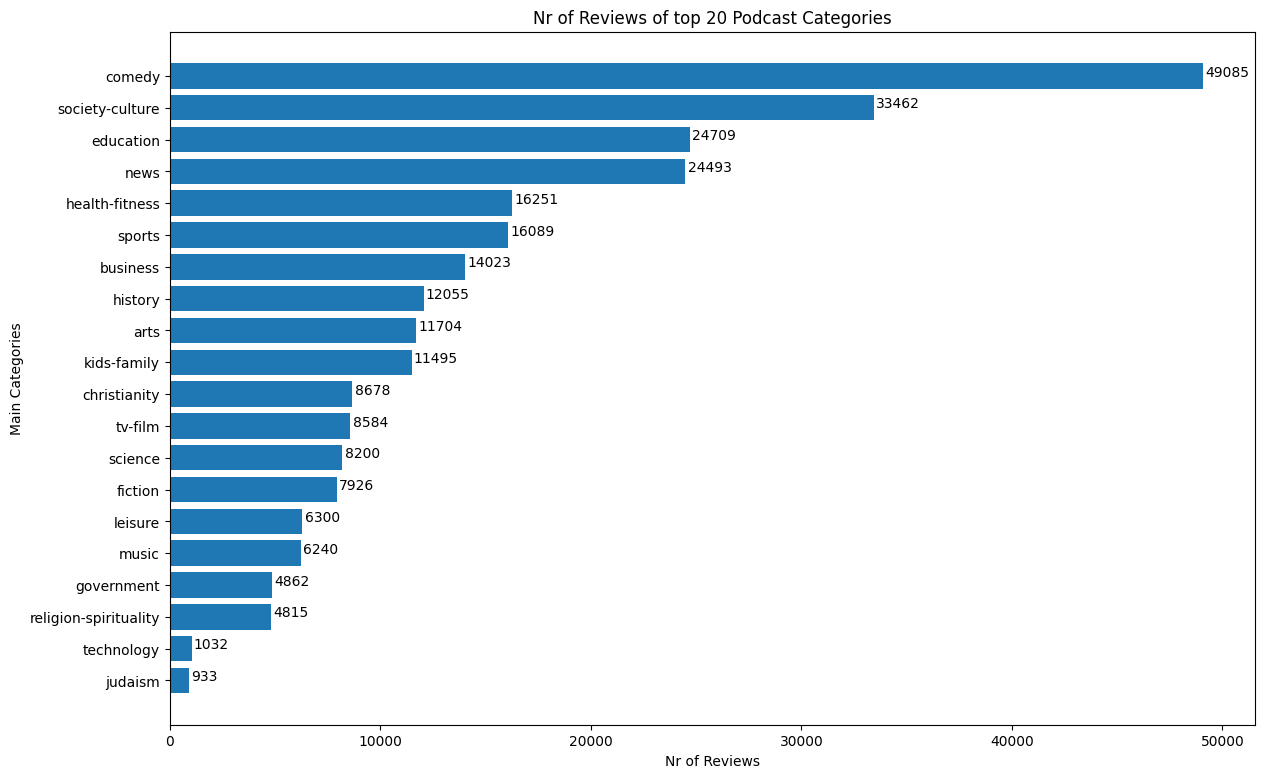

In [25]:
fig, ax = plt.subplots(figsize = (14, 9))
srtd = main_category_table.sort_values(by = ('podcast_id', 'count'))
ax.barh(srtd.index, srtd[('podcast_id', 'count')], align='center')
y = -1
for count_var in srtd[('podcast_id', 'count')]:
    y += 1
    plt.annotate(text = f"{count_var}", xy = (count_var+100, y), color = 'black')

plt.title('Nr of Reviews of top 20 Podcast Categories');
plt.xlabel("Nr of Reviews")
plt.ylabel("Main Categories");

As we've seen previously, more "generalist" categories seem to be receiving the most reviews (probably because of their accessibility), whilst more specialized podcast categories get way less reviews than the more general ones (e.g. `judaism`, `religion-spirituality`, `technology` are only going to be listened to by people who are big fans of the genres already).

What if we split these numbers by combinations of `main_category`-`second_category`? Let's build a contingency table:

In [26]:
contingency_table = pd.crosstab(master_table['main_category'], 
                            master_table['second_category'],  
                               margins = False) 
contingency_table

second_category,,arts-books,arts-fashion-beauty,arts-performing-arts,business-careers,business-entrepreneurship,business-investing,business-management,comedy-comedy-interviews,education,education-self-improvement,fiction-comedy-fiction,fiction-drama,health-fitness,health-fitness-alternative-health,health-fitness-fitness,health-fitness-mental-health,history,kids-family,kids-family-education-for-kids,kids-family-parenting,leisure-games,leisure-hobbies,leisure-video-games,music,music-music-commentary,music-music-interviews,news,news-entertainment-news,news-news-commentary,religion,religion-spirituality,science,science-natural-sciences,science-social-sciences,society-culture,society-culture-documentary,society-culture-personal-journals,society-culture-philosophy,society-culture-relationships,sports-baseball,sports-fantasy-sports,tv-film,tv-film-after-shows,tv-film-film-history
main_category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
arts,2091,2889,1478,5246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
business,5156,0,0,0,1055,4568,1808,1436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
christianity,4300,0,0,0,0,0,0,0,0,716,0,0,0,788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2874,0,0,0,0,0,0,0,0,0,0,0,0,0
comedy,31150,0,0,0,0,0,0,0,4062,0,0,0,0,3463,0,0,0,0,3528,0,0,0,0,0,0,0,0,3034,0,0,0,0,0,0,0,3848,0,0,0,0,0,0,0,0,0
education,1197,0,0,0,0,0,0,0,0,0,10210,0,0,0,0,0,0,0,11238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2064,0,0,0,0,0,0,0,0,0
fiction,5365,0,0,0,0,0,0,0,0,0,0,491,587,986,0,0,0,0,497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
government,1540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,602,0,0,0,0,0,0,0,0,0,2720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
health-fitness,10377,0,0,0,0,0,0,0,0,0,0,0,0,0,2327,1273,2274,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
history,3466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1264,0,0,0,0,0,906,0,0,0,0,0,0,0,1056,0,0,5363,0,0,0,0,0,0,0,0,0


Interestingly, there seems to not be a lot of cross-classification from the secondary categories - most secondary categories are just smaller subsections of the main category. Another fascinating bit is that a lot of podcasts are purely in one specific category (the first column is fully filled up). This can either mean that the main category is actually just an umbrella term that is used for podcasts that are less known or that there are actually so many `"generalist"` podcasts out there.

Lastly, the `kids-family` sub-category seems to be qutie cross-polinated with different main categories as well (e.g. `comedy`, `education`, `fiction`, etc.). The same can be said for the `society-culture` sub-category.  

There are also some unusual combinations that seem to be quite popular: `comedy`-`news` (perhaps a more cheerful spinoff of the gloomy news world we get today) or  `history`-`music` (perhaps these are podcasts that focus on medieval music?) or even `christianity`-`education` (what an interesting twist).

Now, since in the current dataset we have mostly 3 specific dimensions: podcast `rating`, `sentiment compound score` & `positive reviews proportion` - we will be using these to determine the quality/positivity for each podcast. Let's first look at how they are distributed:

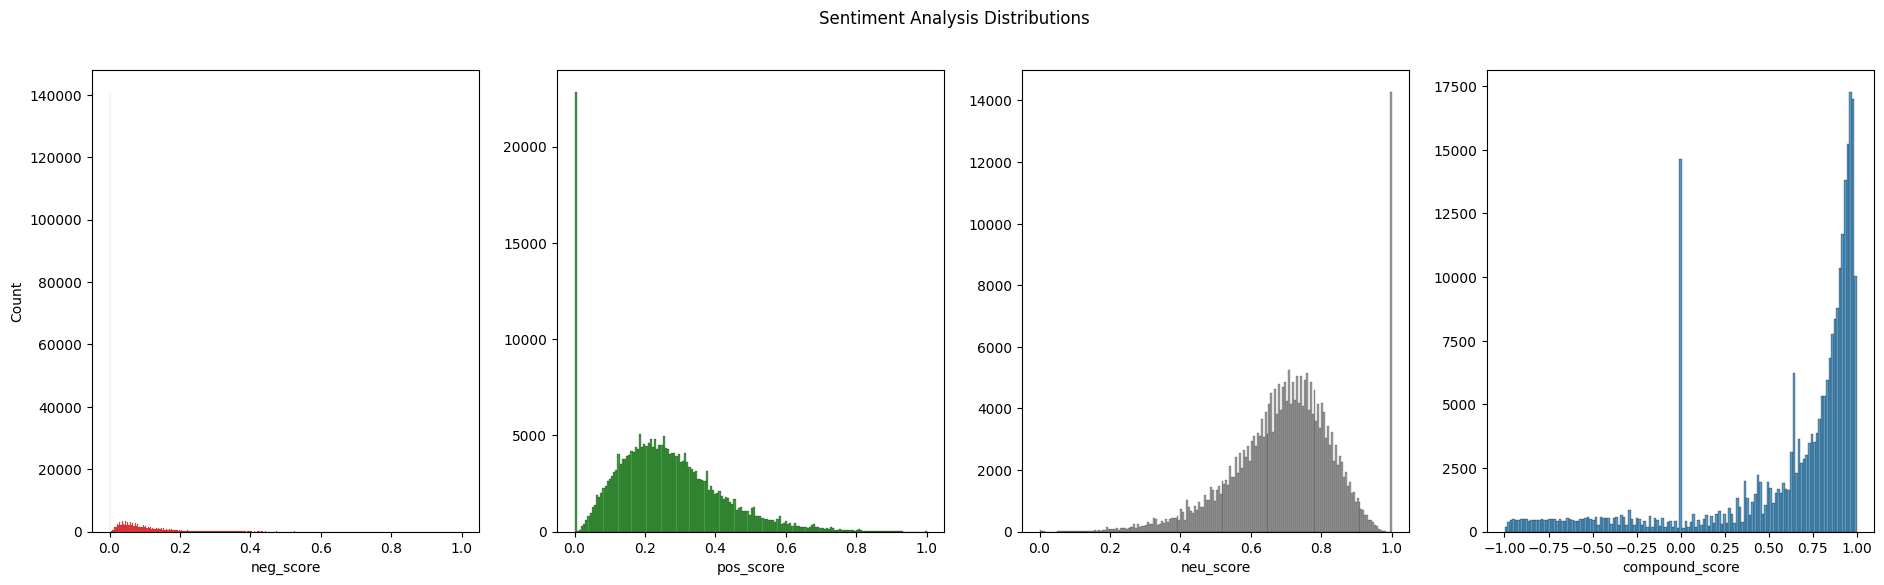

In [27]:
fig, ax = plt.subplots(1, 4, figsize = (23, 6))

sns.histplot(data = master_table['neg_score'], ax = ax[0], color = 'red')
sns.histplot(data = master_table['pos_score'], ax = ax[1], color = 'green')
sns.histplot(data = master_table['neu_score'], ax = ax[2], color = 'grey')
sns.histplot(data = master_table['compound_score'], ax = ax[3])
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
plt.suptitle('Sentiment Analysis Distributions');

This is very interesting! It seems that generally we have `very low` number of observations for the `neg_score`, which coincides with our previous observation that generally most reviews are more positive than negative.
`Pos_score` seems to be showing higher values (again aligning with out observations), but then those values are actually mostly situated `<0.5`. Surprisingly, the highest values that we see between the three is actually for `neu_score`, which is the probability that the reviews are mostly neutral (not falling in either being negative or positive towards the podcast). There even is a sizeable majority of `neu_score = 1`, which is surprising. This, coupled with the fact that there are much more positive than negative observations, is probably the reason why we see such a high skew towards the `left` on the `sentiment compound score`.

Whilst the `compound_score` chart displays high skewness, because of the large amount of observations we can inact the Central Limit Theorem and state that sample means of this distribution are `normally distributed`.

Now let's quickly look at the `reviews` disribution.

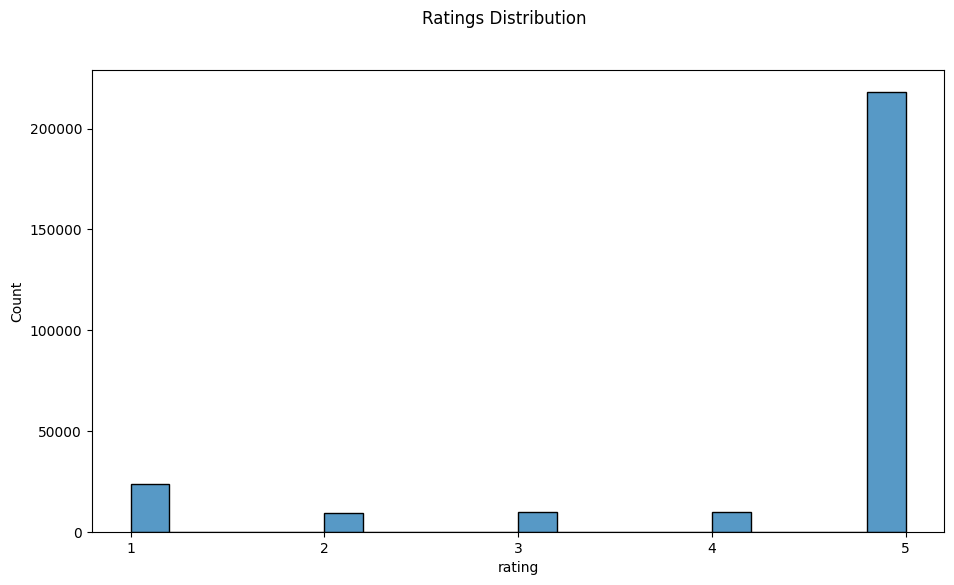

In [28]:
fig = plt.figure(figsize = (11, 6))

sns.histplot(data = master_table['rating'])
plt.xticks([1, 2, 3, 4, 5])
plt.suptitle('Ratings Distribution');

This is actually quite expected, because we have previously seen that most of the mean ratings for all categories actually fall in the range `4`-`5`, which would only make sense if most of all `reviews` were rated as `5`.

What about the `proportion of positive reviews` per `main_category`?

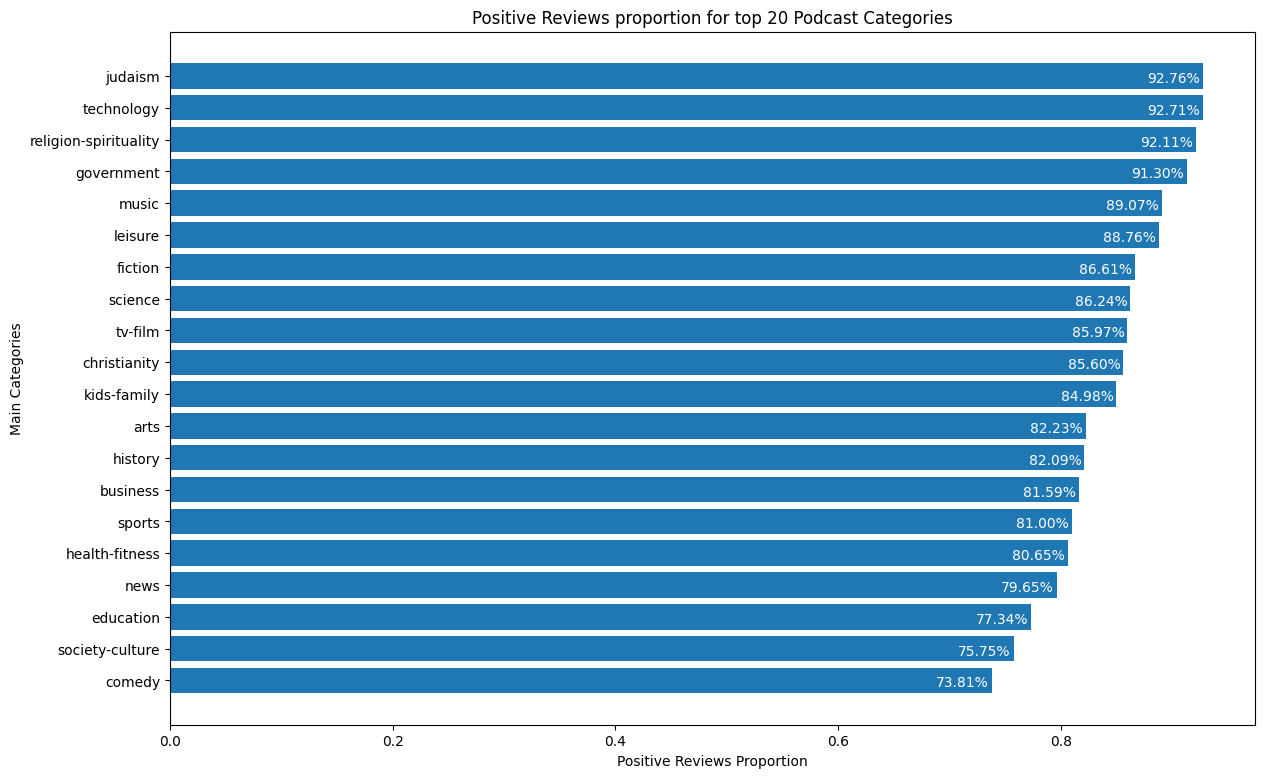

In [29]:
fig, ax = plt.subplots(figsize = (14, 9))
ax.barh(main_category_table.index, sorted(main_category_table[('sentiment_bool', '<lambda>')]), align='center')
y= -1
for proportion in sorted(main_category_table[('sentiment_bool', '<lambda>')]):
    y += 1
    plt.annotate(text = f"{proportion*100:.2f}%", xy = (proportion-0.05, y-0.2), color = 'white')

plt.title('Positive Reviews proportion for top 20 Podcast Categories');
plt.xlabel("Positive Reviews Proportion")
plt.ylabel("Main Categories");

Interestingly, `comedy` & `society-culture` seem to be at the bottom of the entire list of categories, which is quite surprising (especially for the first one). The same thing for `education`, which is actually even more surprising. Also surprisingly, `government` podcasts have the 4th highest proportion of positive reviews, which actually somewhat contradicts what we had seen previously. 

Having reviewed all the distributions of the main variables in the dataset, I have come up with a list of questions I wanted to answer with statistical significance to be for sure on the results we see in the results here. Let's dive into statistical inference specifically for this reason.

## Questions to be Answered:

1.1. What is the true population mean compound sentiment' score for `society-culture` podcasts?

1.2. What are the true population mean compound `sentiment` scores for other podcast categories? 

2.1. Does `science` and `history` have the same average `rating`, `compound sentiment scores` & `the proportion of positive reviews`?

3.1. Do the `news` podcasts have a bigger proportion of negative reviews to the other podcast categories on average?

3.2. Do the `news` podcasts have less positive reviews to the other podcast categories on average based on sentiment' compound score?

4.1. Do the `comedy` podcasts have the biggest proportion of positive reviews to the other podcast categories on average?

4.2. Do the `comedy` podcasts have the most positive reviews compared to the other podcast categories on average based on sentiment compound score?

5.1. Do `educational` podcasts get `better` reviews for `education-self_improvement` subcategory (prioritized for adults) or the `kids-family`(prioritized for children) subcategory? 

6.1. Do `general` business podcasts get `better` review ratings than business podcasts with other subcategories on average? 

### Question 1.1: What is the true population mean compound `sentiment` score for `society-culture` podcasts?

In [30]:
society_df = master_table[master_table.main_category == 'society-culture']['compound_score'].values
n_obs = len(society_df)
print(f"Number of Observations: {n_obs}")
best_estimate = society_df.mean()
print(f"Best estimate: {best_estimate}")
estimate_standard_error = stats.sem(society_df)
print(f"Estimated standard error: {estimate_standard_error}")
median = statistics.median(society_df)
print(f"Median: {median}")

Number of Observations: 33462
Best estimate: 0.49580633853326156
Estimated standard error: 0.0031321033674245793
Median: 0.76885


In [31]:
conf_interval = stats.norm.interval(alpha=0.95, loc=best_estimate, scale=estimate_standard_error) 
print(f"Lower Limit: {conf_interval[0]}, Upper Limit: {conf_interval[1]}")

Lower Limit: 0.4896675287372528, Upper Limit: 0.5019451483292704


With 95% confidence, we can specify that the true population of the mean sentiment compound score is between `0.5858843807976221` (lower limit) & `0.5946764504135423` (upper limit). Now let's try the hypothesis testing approach to potentially identify the true population `rating` mean of `society-culture` podcasts?

We assume that the sentiment score mean for `society-culture` podcasts 0.5 (close to the `best_estimate`):

H0 : `sentiment_score_mean_society` = 0.5

H1 : `sentiment_score_mean_society` != 0.5

Significance Level: `5%`. Since the number of observations is `33462`, this yields us the plausible ability to envoke the Central Limit Theorem and use an approximation to the normal distribution

In [32]:
ztest_results = ztest(society_df, value = 0.5)
print(f"Statistic: {ztest_results[0]}, P-value {ztest_results[1]}")
print(f"We fail to reject the null hypothesis, because the {round(ztest_results[1], 3)} > 0.05.")
print("Which means that the true population mean compound sentiment score for society-culture podcasts is equal to somewhere around 0.5")

Statistic: -1.3389281817307153, P-value 0.18059405417259988
We fail to reject the null hypothesis, because the 0.181 > 0.05.
Which means that the true population mean compound sentiment score for society-culture podcasts is equal to somewhere around 0.5


This begs the question - what is the distribution of this variable and perhaps it has quite large skewness that the mean is not a good indicator of centrality of the distribution?

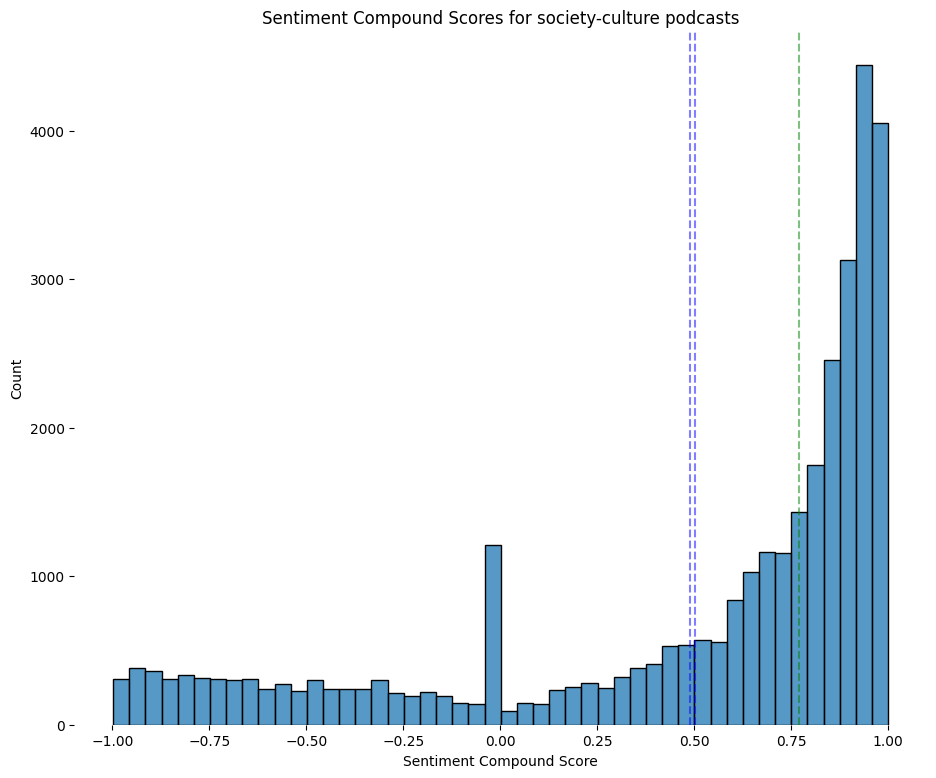

In [33]:
fig = plt.figure(figsize=(11, 9))
remove_borders()
sns.histplot(data = society_df)
plt.axvline(x = median, color = 'green', linestyle = '--', alpha = 0.5)
plt.axvline(x = conf_interval[1], color = 'blue', linestyle = '--', alpha = 0.5)
plt.axvline(x = conf_interval[0], color = 'blue', linestyle = '--', alpha = 0.5)
plt.title('Sentiment Compound Scores for society-culture podcasts');
plt.xlabel('Sentiment Compound Score');

From the chart above we can see how the data is actually heavily skewed to the left. However, since the number of observations is so high, we can still assume that the underlying sample mean distribution is normal and thus our results hold. What about the underlying mean of `sentiment compound score` for other categories as well?


### Question 1.2: What are the true population mean compound `sentiment` scores for other podcast categories, as well? 
For this use case, since there are a lot of categories in the dataset, we will only be using Confidence Intervals

In [34]:
df = master_table[['main_category', 'compound_score']]
df_dict = df.groupby('main_category')['compound_score'].apply(list)
best_estimates = df.groupby('main_category').mean()
confidence_intervals = {}
for category, be in zip(best_estimates.index, best_estimates.values):
    ttest = stats.ttest_1samp(df_dict[category], *be, alternative='two-sided')
    ci = stats.norm.interval(alpha=0.95, loc=be[0], scale=stats.sem(df_dict[category]))
    confidence_intervals[category] = *be, ttest.pvalue, ci[0], ci[1]
    

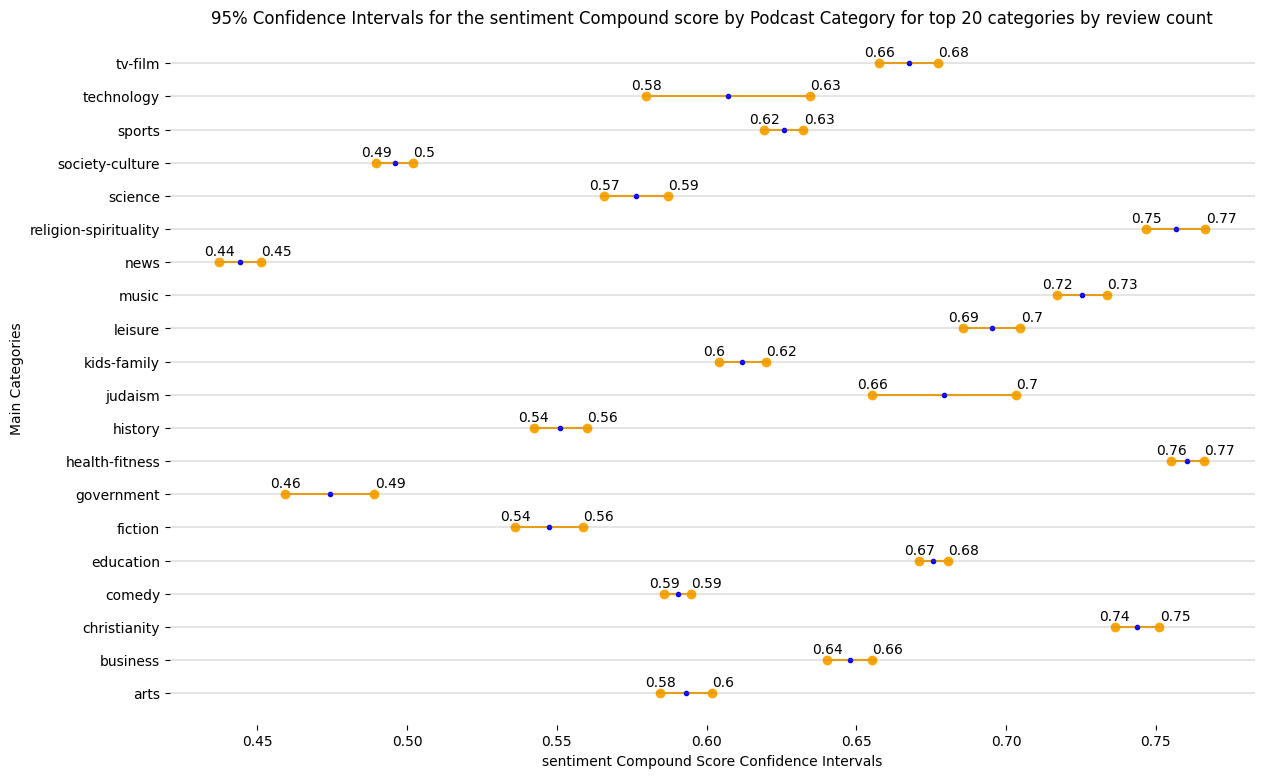

In [35]:
fig = plt.figure(figsize=(14, 9))
remove_borders()
y = -1
for key in confidence_intervals.keys():
    be = confidence_intervals[key][0]
    lower = confidence_intervals[key][2]
    upper = confidence_intervals[key][3]
    y += 1
    plt.plot((lower,upper),(y,y),'ro-',color='orange');
    plt.plot(be, y, '.',color = 'blue')
    plt.annotate(text = round(lower, 2), xy = (lower-0.005, y + 0.2))
    plt.annotate(text = round(upper, 2), xy = (upper+0.0001, y + 0.2))
    plt.axhline(y = y, alpha = 0.2,color = 'grey')


plt.yticks(range(len(confidence_intervals.keys())),list(confidence_intervals.keys()));
plt.title("95% Confidence Intervals for the sentiment Compound score by Podcast Category for top 20 categories by review count");
plt.xlabel("sentiment Compound Score Confidence Intervals")
plt.ylabel("Main Categories");

There are certainly very interesting insights that can be pulled from this:
1. `Technology` & `Judaism` seem to be displaying the biggest standard errors in their distributions, whilst `Sports`, `health-fitness`, `society-culture` & `education` are displaying the lowest standard errors - this is mostly with regards to these categories having loads of reviews. 
2. `Religion-spirituality`, `health-fitness` & `christianity` seem to be displaying the most positive review sentiments out of all podcast categories. This might be linked to these podcast being positive in general and a form of selection bias creeping in - for more niche podcasts, only people that are very interested in the subject will listen providing a better chance for the podcasts to be successful.
3. `News`, `Society-culture` & `government` seem to be showing the least positive reviews out of all podcast categories. This can be more linked with the times of the analysis more than anything - during the analysis period a lot of negative change happened in the `news` & `government` sections (think: Covid, Trump Elections, War in Ukraine, etc.)

Well then what about the `ratings` and their distribution?

In [36]:
df_ratings = master_table[['main_category', 'rating']]
best_estimates_rating = df_ratings.groupby('main_category').agg(mean = ('rating', lambda x: x.mean()),
                                                        sem = ('rating', lambda x: stats.sem(x)))

confidence_intervals_ratings = {}
for category, be, sem in zip(best_estimates_rating.index, best_estimates_rating['mean'], best_estimates_rating['sem']):
    ttest = stats.ttest_1samp(df_dict[category], be, alternative='two-sided')
    ci = stats.norm.interval(alpha=0.95, loc=be, scale=sem)
    confidence_intervals_ratings[category] = be, ttest.pvalue, ci[0], ci[1]

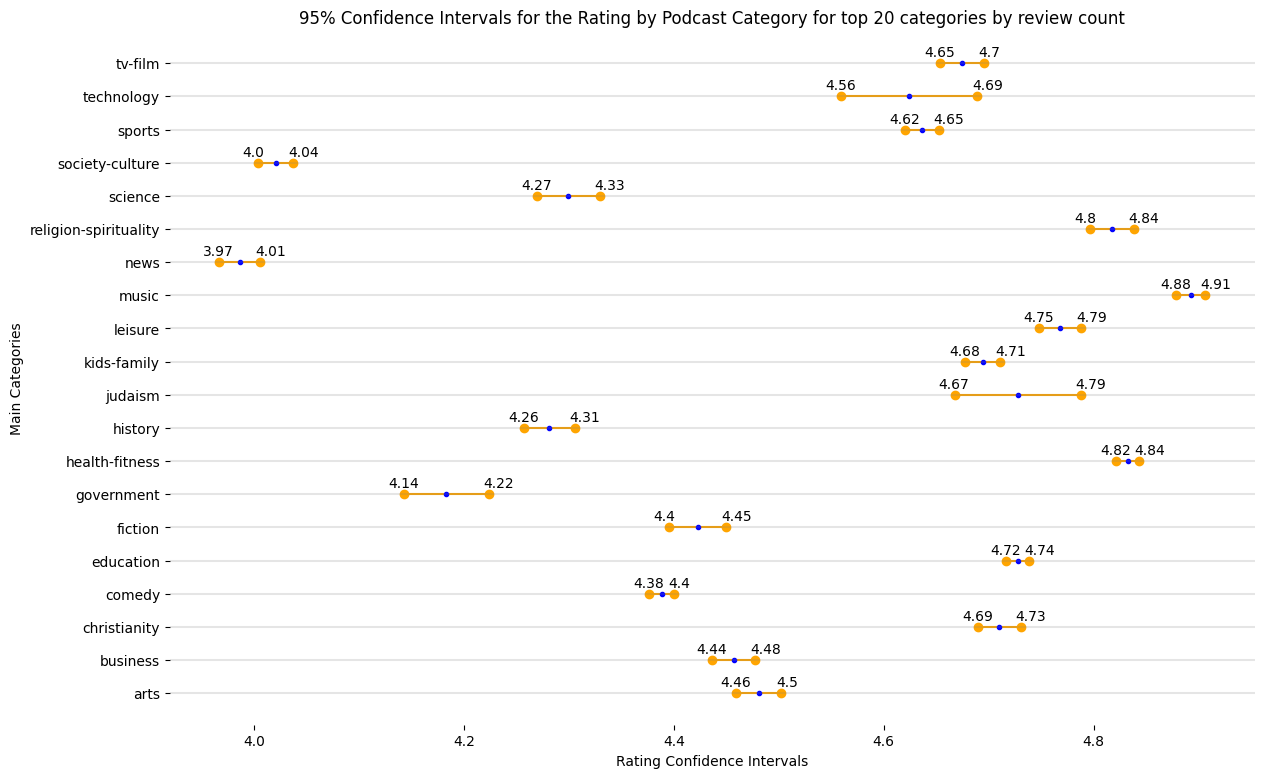

In [37]:
fig = plt.figure(figsize=(14, 9))
remove_borders()
y = -1
for key in confidence_intervals_ratings.keys():
    be = confidence_intervals_ratings[key][0]
    lower = confidence_intervals_ratings[key][2]
    upper = confidence_intervals_ratings[key][3]
    y += 1
    plt.plot((lower,upper),(y,y),'ro-',color='orange');
    plt.plot(be, y, '.',color = 'blue')
    plt.annotate(text = round(lower, 2), xy = (lower-0.015, y + 0.2))
    plt.annotate(text = round(upper, 2), xy = (upper-0.005, y + 0.2))
    plt.axhline(y = y, alpha = 0.2,color = 'grey')


plt.yticks(range(len(confidence_intervals_ratings.keys())),list(confidence_intervals_ratings.keys()));
plt.title("95% Confidence Intervals for the Rating by Podcast Category for top 20 categories by review count");
plt.xlabel("Rating Confidence Intervals")
plt.ylabel("Main Categories");

Interesting learning points:
1. Most averages fall in the range of `4`-`5` with the exception of `news`, which has a 95% confidence interval encroaching on `3.97`. This most likely means that, as with any rating system done by humans, these values are subjective and biased towards the larger values. 
2. The highest average ratings are displayed by `music` podcasts - perhaps it speaks to the niche of the podcasts or the fact that mostly very big music-heads actually create podcasts on music. `Religion-sprituality` & `health-fitness` come in as close seconds.
3. The lowest average ratings are displayed by `news` & `society-culture` podcasts.

Now, from these two charts we can see that the `history` and `science` categories have very similar `sentiment compound score` & `rating` values. Let's try to figure out whether hypothesis testing brings back the same result?

### Question 2: Does `science` and `history` have the same average `rating`, `compound sentiment scores` & `the proportion of positive reviews`?

In [38]:
history_df = master_table[master_table.main_category == 'history']
science_df = master_table[master_table.main_category == 'science']

Let's first look at the distributions between these podcast categories in terms of their `rating`, `compound sentiment score` & `sentiment_bool` variables:

P.s.: the orange lines are `science` mean values for all 3 variables & the green lines represent the `history` mean values for all 3 variables.

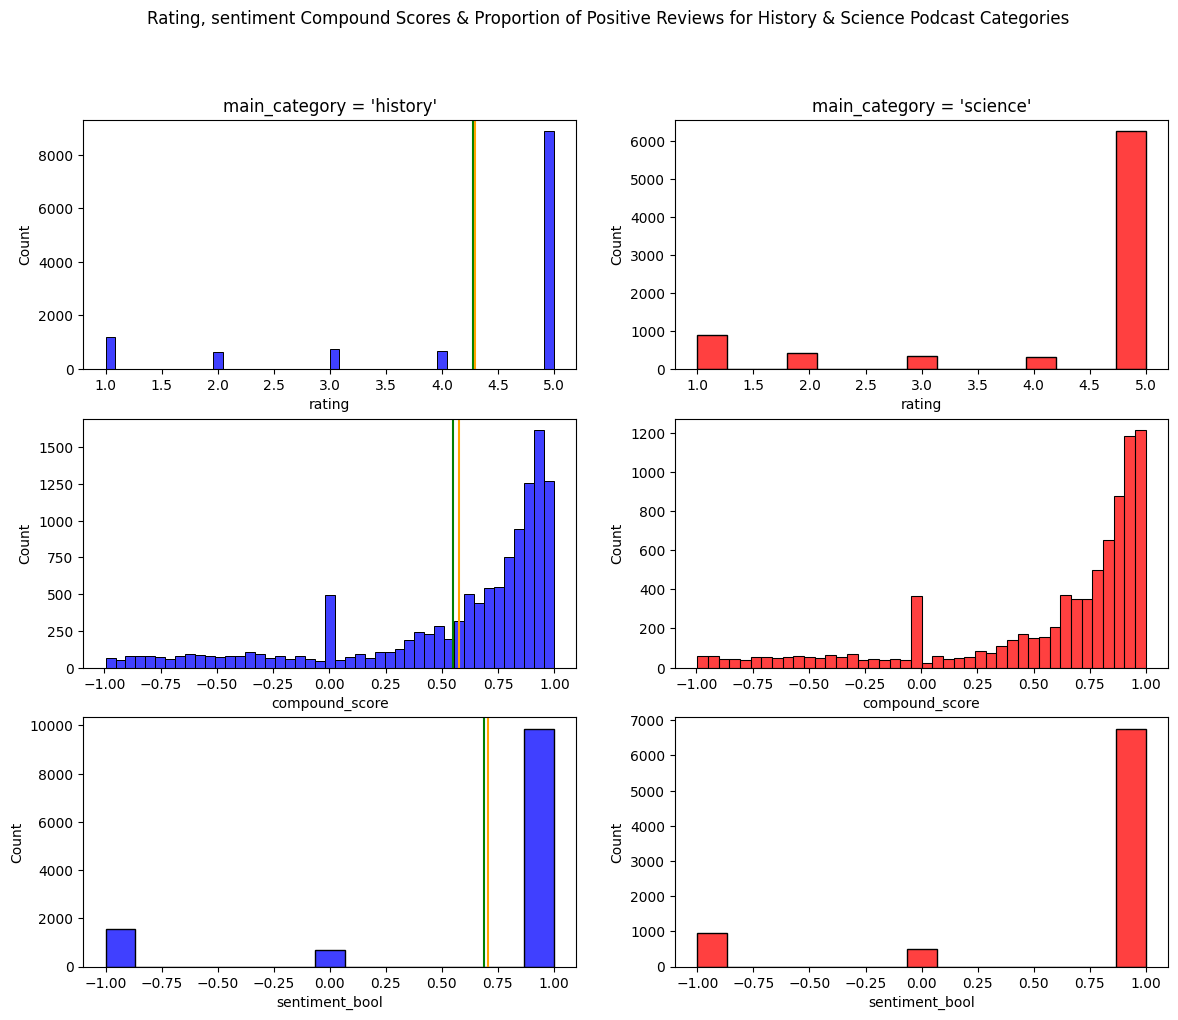

In [39]:
fig, ax = plt.subplots(3, 2, figsize = (14, 11))
a = history_df['rating']
b = science_df['rating']
c = history_df['compound_score']
d = science_df['compound_score']
e = history_df['sentiment_bool']
f = science_df['sentiment_bool']
# remove_borders()

sns.histplot(data = a, color='blue', ax = ax[0][0])
ax[0][0].axvline(x = a.mean(), color = 'green')
sns.histplot(data = b, color='red', ax = ax[0][1])
ax[0][0].axvline(x = b.mean(), color = 'orange')
sns.histplot(data = c, color='blue', ax = ax[1][0])
ax[1][0].axvline(x = c.mean(), color = 'green')
sns.histplot(data = d, color='red', ax = ax[1][1])
ax[1][0].axvline(x = d.mean(), color = 'orange')
sns.histplot(data = e, color='blue', ax = ax[2][0])
ax[2][0].axvline(x = e.mean(), color = 'green')
sns.histplot(data = f, color='red', ax = ax[2][1])
ax[2][0].axvline(x = f.mean(), color = 'orange')

plt.suptitle("Rating, sentiment Compound Scores & Proportion of Positive Reviews for History & Science Podcast Categories")
ax[0][0].set_title("main_category = 'history'")
ax[0][1].set_title("main_category = 'science'");

The orange line seems to be ever so slightly above the green line in all three variables' distributions, which indicates that the `science` podcasts might be outperforming the `history` podcasts in every front. But let's check that out via inference testing: 

In [40]:
print(f"Science category rating mean: {science_df.rating.mean()}")
print(f"History category rating mean: {history_df.rating.mean()}")
print(f"Science category rating standard deviation: {science_df.rating.std()}")
print(f"History category rating standard deviation: {history_df.rating.std()}")

Science category rating mean: 4.299390243902439
History category rating mean: 4.281294068851099
Science category rating standard deviation: 1.3411439083684746
History category rating standard deviation: 1.3411439083684746


Because of the fact that Science and History seem to display practically the same standard deviation. We can assume to be able to use the pooled standard deviation approach for the z-test, which states that the two values essentially vary in the same magnitude 

We assume that the rating mean for news podcasts is not the same as the rating mean  for other podcasts:

H0 : `rating_mean_history` - `rating_mean_science` = 0

H1 : `rating_mean_history` - `rating_mean_science` != 0

Significance Level: `5%`

In [41]:
results = ztest(history_df['rating'], science_df['rating'], value=0, alternative='two-sided')
print(f"We fail to reject the null hypothesis, because the {round(results[1], 3)} > 0.05.")
print("Which means that the difference between the true population mean ratings between history and science is insignificant.")

We fail to reject the null hypothesis, because the 0.351 > 0.05.
Which means that the difference between the true population mean ratings between history and science is insignificant.


What about `compound sentiment score`?

We assume that the sentiment score mean for history podcasts is different from the sentiment score mean for science podcasts:

H0 : `sentiment_score_mean_history` - `sentiment_score_mean_science` = 0

H1 : `sentiment_score_mean_history` - `sentiment_score_mean_science` != 0

Significance Level: `5%`

In [42]:
results = ztest(history_df['compound_score'], science_df['compound_score'], value=0, alternative='two-sided')
print(f"We reject the null hypothesis, because the {round(results[1], 3)} < 0.05.")
print("Which means that the difference between the true population mean compound sentiment scores between history and science is not equal to 0.")

We reject the null hypothesis, because the 0.0 < 0.05.
Which means that the difference between the true population mean compound sentiment scores between history and science is not equal to 0.


Interesting, finally let's look at the `proportion of positive reviews`:

We assume that the positive reviews proportion for history podcasts is smaller from the positive reviews proportion for other podcasts:

H0 : `positive_reviews_proportion_news` - `positive_reviews_proportion_other` <= 0

H1 : `positive_reviews_proportion_news` - `positive_reviews_proportion_other` > 0

Significance Level: `5%`

In [43]:
count1 = master_table[(master_table.main_category == 'history') & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs1 = master_table[master_table.main_category == 'history']['sentiment_bool'].count()
count2 = master_table[(master_table.main_category == 'science') & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs2 = master_table[master_table.main_category == 'science']['sentiment_bool'].count()


print(f"Count 1: {count1}, Nr. of Obs 1: {nobs1}, Count 2: {count2}, Nr. of Obs 2: {nobs2}")
print(f"History Positive Reviews Proportion: {count1*100.0/nobs1:.2f}%")
print(f"Science Positive Reviews Proportion: {count2*100.0/nobs2:.2f}%")

Count 1: 9836, Nr. of Obs 1: 12055, Count 2: 6743, Nr. of Obs 2: 8200
History Positive Reviews Proportion: 81.59%
Science Positive Reviews Proportion: 82.23%


In [44]:
test_results = statsmodels.stats.proportion.test_proportions_2indep(count1 = count1, 
                                                     nobs1 = nobs1,
                                                     count2 = count2,
                                                     nobs2 = nobs2, 
                                                     compare='diff',
                                                     alternative='two-sided')
test_results

<class 'statsmodels.stats.base.HolderTuple'>
statistic = -1.1565009793940257
pvalue = 0.24747629919798542
compare = 'diff'
method = 'agresti-caffo'
diff = -0.006390071926434704
ratio = 0.9922291873354939
odds_ratio = 0.9577840709010271
variance = 3.027975306274793e-05
alternative = 'two-sided'
value = 0
tuple = (-1.1565009793940257, 0.24747629919798542)

Since the p-value for the 2 sample proportion test is ~0.247476, which > 0.05, we fail to reject the null hypothesis that the true population proportions of positive reviews between podcasts specializing towards `history` and `science` are the same and falls roughly on `~82-86%`.

### Question 3.1: Do the `news` podcasts have a bigger proportion of negative reviews to the other podcast categories on average?
### Question 3.2: Do the `news` podcasts have less positive reviews to the other podcast categories on average based on sentiment compound score?

In [45]:
positive_proportion_news = main_category_table[main_category_table.index == 'news']['sentiment_bool'].values[0][0]
print(f"The average positive proportion for news podcasts: {positive_proportion_news}")
mean_positive_proportion = main_category_table[main_category_table['sentiment_bool'].index != 'news'].sentiment_bool.mean()[0]
print(f"The average positive proportion for all other podcasts: {mean_positive_proportion}")

The average positive proportion for news podcasts: 0.7381292614216307
The average positive proportion for all other podcasts: 0.8507415392022354


In [46]:
compound_score_news = main_category_table[main_category_table.index == 'news'][('compound_score', 'mean')].values[0]
print(f"The average sentiment compound score for news podcasts: {compound_score_news}")
mean_compound_score = main_category_table[main_category_table.index != 'news'][('compound_score', 'mean')].mean()
print(f"The average sentiment compound score for all other podcasts: {mean_compound_score}")

The average sentiment compound score for news podcasts: 0.4441907034662965
The average sentiment compound score for all other podcasts: 0.6328563075723865


Already from this, we can see that `News` agencies perhaps have a tendency to be reviewed as more `negative` than the other podcast categories on average. But before jumping to conclusions, a proper analysis should be done.

P.s.: the green line symbolizes the mean variable of choice for the `news` podcasts & the orange line - the mean variable of choice for the `other` podcasts.

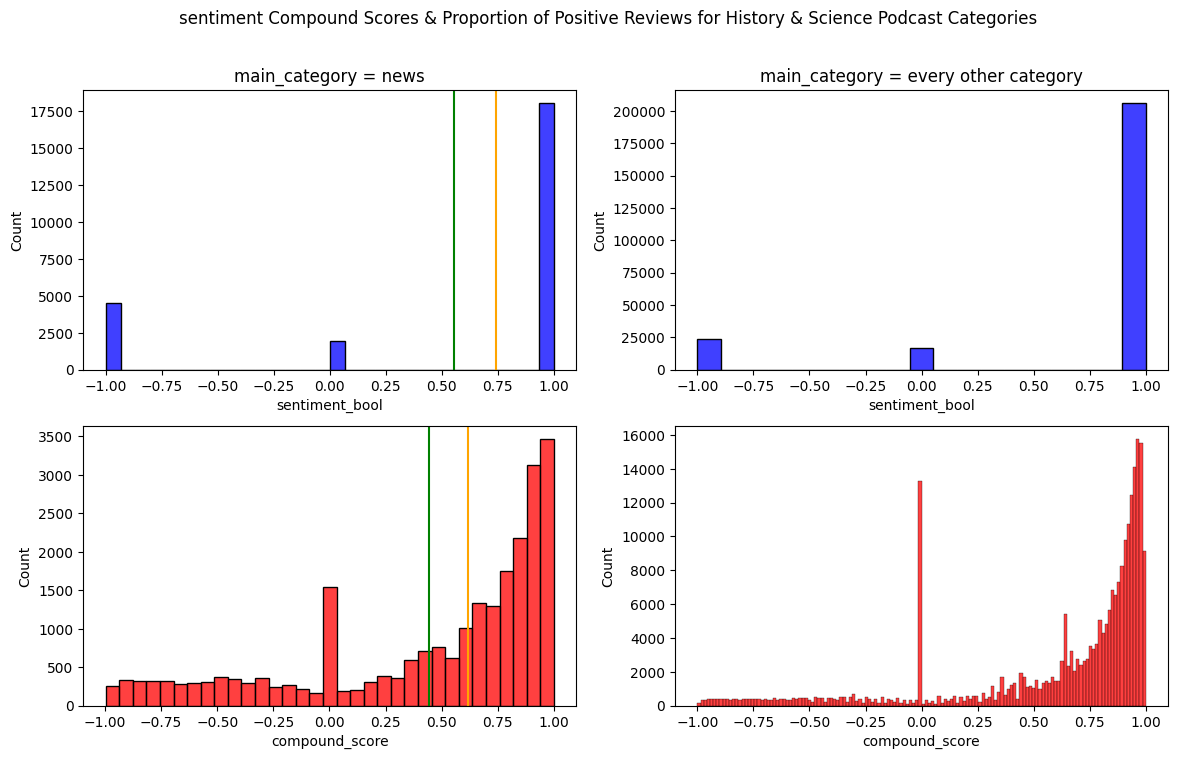

In [47]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
a = master_table[master_table.main_category == 'news']['sentiment_bool']
b = master_table[master_table.main_category == 'news']['compound_score']
c = master_table[master_table.main_category != 'news']['sentiment_bool']
d = master_table[master_table.main_category != 'news']['compound_score']

sns.histplot(data = a, color='blue', ax = ax[0][0])
ax[0][0].axvline(x = a.mean(), color = 'green')
sns.histplot(data = b, color='red', ax = ax[1][0])
ax[1][0].axvline(x = b.mean(), color = 'green')
sns.histplot(data = c, color='blue', ax = ax[0][1])
ax[0][0].axvline(x = c.mean(), color = 'orange')
sns.histplot(data = d, color='red', ax = ax[1][1])
ax[1][0].axvline(x = d.mean(), color = 'orange')

plt.suptitle("sentiment Compound Scores & Proportion of Positive Reviews for History & Science Podcast Categories")
ax[0][0].set_title("main_category = news")
ax[0][1].set_title("main_category = every other category");

We can already see that there seems to be a big gap between the averages (and not in the `News` podcasts' favour). Thus, our null assumption will be that the news podcasts have a smaller proportion of positive reviews compared to the other podcasts.

We assume that the positive reviews proportion for news podcasts is smaller from the positive reviews proportion for other podcasts:

H0 : `positive_reviews_proportion_news` - `positive_reviews_proportion_other` <= 0

H1 : `positive_reviews_proportion_news` - `positive_reviews_proportion_other` > 0

Significance Level: `5%`

In [48]:
count1 = master_table[(master_table.main_category == 'news') & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs1 = master_table[master_table.main_category == 'news']['sentiment_bool'].count()
count2 = master_table[(master_table.main_category != 'news') & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs2 = master_table[master_table.main_category != 'news']['sentiment_bool'].count()


print(f"Count 1: {count1}, Nr. of Obs 1: {nobs1}, Count 2: {count2}, Nr. of Obs 2: {nobs2}")
print(f"News agency proportion: {100*count1 / nobs1:.3f}%")
print(f"News agency proportion: {100*count2 / nobs2:.3f}%")

Count 1: 18079, Nr. of Obs 1: 24493, Count 2: 206126, Nr. of Obs 2: 246443
News agency proportion: 73.813%
News agency proportion: 83.640%


In [49]:
test_results = statsmodels.stats.proportion.test_proportions_2indep(count1 = count1, 
                                                     nobs1 = nobs1,
                                                     count2 = count2,
                                                     nobs2 = nobs2, 
                                                     compare='diff',
                                                     alternative='smaller')
test_results

<class 'statsmodels.stats.base.HolderTuple'>
statistic = -33.81983753567891
pvalue = 5.039437197211556e-251
compare = 'diff'
method = 'agresti-caffo'
diff = -0.09827509983026117
ratio = 0.88250288451011
odds_ratio = 0.5513163626919434
variance = 8.446789206353213e-06
alternative = 'smaller'
value = 0
tuple = (-33.81983753567891, 5.039437197211556e-251)

From the Z-test we can understand that we have to reject the null hypothesis, because the p-value is 5.0395e-251, which is < 0.05. This means that the proportion of positive comments for `news` podcasts is much smaller than the proportion of positive comments for other podcasts.

Now let's look at the sentiment compound score. We assume that the compound score for news podcasts mean is higher than the sentiment compound score mean for other categories:

H0 : `compound_score_mean_news` - `compound_score_mean_others` >= 0

H1 : `compound_score_mean_news` - `compound_score_mean_others` < 0

Significance Level: `5%`

In [50]:
news_df = master_table[master_table.main_category == 'news']['compound_score']
other_categories_df = master_table[master_table.main_category != 'news']['compound_score']

results = ztest(news_df, other_categories_df, value=0, alternative="smaller")
print(f"We reject the null hypothesis, because the {round(results[1], 3)} < 0.05.")
print("Which means that the true population mean sentiment compound score for news podcasts is smaller than the true population score for mean sentiment compound score for other podcast categories.")

We reject the null hypothesis, because the 0.0 < 0.05.
Which means that the true population mean sentiment compound score for news podcasts is smaller than the true population score for mean sentiment compound score for other podcast categories.


#### Question 4.1: Do the `comedy` podcasts have the biggest proportion of positive reviews to the other podcast categories on average?
#### Question 4.2: Do the `comedy` podcasts have the most positive reviews compared to the other podcast categories on average based on sentiment compound score?

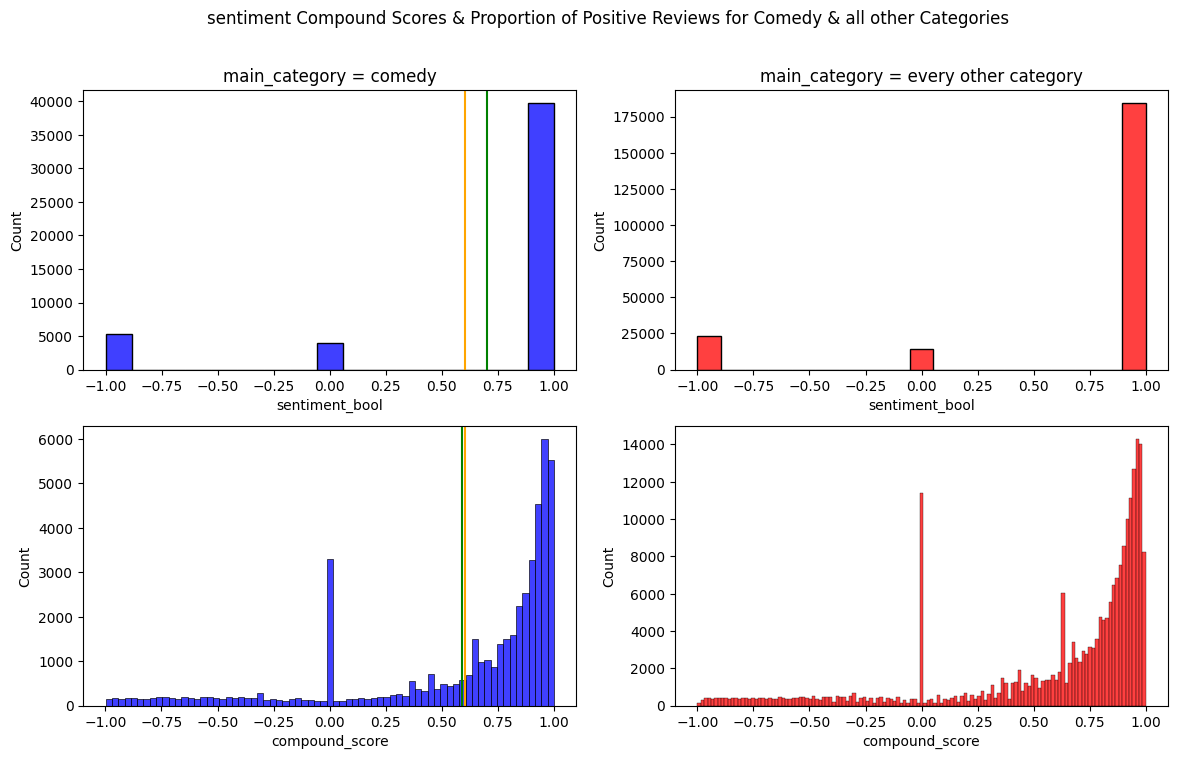

In [51]:
a = master_table[master_table.main_category == 'comedy']['sentiment_bool']
b = master_table[master_table.main_category == 'comedy']['compound_score']
c = master_table[master_table.main_category != 'comedy']['sentiment_bool']
d = master_table[master_table.main_category != 'comedy']['compound_score']

fig, ax = plt.subplots(2, 2, figsize = (14, 8))

sns.histplot(data = a, color='blue', ax = ax[0][0])
ax[0][0].axvline(x = a.mean(), color = 'green')
sns.histplot(data = b, color='blue', ax = ax[1][0])
ax[1][0].axvline(x = b.mean(), color = 'green')
sns.histplot(data = c, color='red', ax = ax[0][1])
ax[0][0].axvline(x = d.mean(), color = 'orange')
sns.histplot(data = d, color='red', ax = ax[1][1])
ax[1][0].axvline(x = d.mean(), color = 'orange')

plt.suptitle("sentiment Compound Scores & Proportion of Positive Reviews for Comedy & all other Categories")
ax[0][0].set_title("main_category = comedy")
ax[0][1].set_title("main_category = every other category");

P.s.: The green line is the mean variable of choice for the `comedy` podcasts, whereas the orange line represenet all the other podcasts' average variable of choice.

This actually a much more competitive matchup than the news not being the most negatively reviewed category. In terms of the proportion of positive reviews, the `comedy` category seems to be winning, whereas for the mean sentiment compound score - losing.

We assume that the proportion of positive reviews for comedy podcasts is higher than the proportion of positive reviews for other categories:

H0 : `proportion_positive_reviews_comedy` <= `proportion_positive_reviews_others`

H1 : `proportion_positive_reviews_comedy` > `proportion_positive_reviews_others`

Significance Level: `5%`

In [52]:
count1 = master_table[(master_table.main_category == 'comedy') & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs1 = master_table[master_table.main_category == 'comedy']['sentiment_bool'].count()

highest_proportion = main_category_table['sentiment_bool'].idxmax()[0]

count2 = master_table[(master_table.main_category == highest_proportion) & (master_table.sentiment_bool == 1)]['sentiment_bool'].count()
nobs2 = master_table[master_table.main_category == highest_proportion]['sentiment_bool'].count()

print(f"Count 1: {count1}, Nr. of Obs 1: {nobs1}, Count 2: {count2}, Nr. of Obs 2: {nobs2}")
print(f"Comedy Proportion of Positive Reviews: {count1 / nobs1}")
print(f"Other podcasts Proportion of Positive Reviews: {count2 / nobs2}")

Count 1: 39758, Nr. of Obs 1: 49085, Count 2: 15075, Nr. of Obs 2: 16251
Comedy Proportion of Positive Reviews: 0.8099826831007436
Other podcasts Proportion of Positive Reviews: 0.9276352224478494


In [53]:
test_results = statsmodels.stats.proportion.test_proportions_2indep(count1 = count1, 
                                                     nobs1 = nobs1,
                                                     count2 = count2,
                                                     nobs2 = nobs2, 
                                                     compare ='diff',
                                                     alternative ='larger')
test_results

<class 'statsmodels.stats.base.HolderTuple'>
statistic = -43.624293761430685
pvalue = 1.0
compare = 'diff'
method = 'agresti-caffo'
diff = -0.11765253934710573
ratio = 0.8731693919117867
odds_ratio = 0.3325313178932187
variance = 7.268595343924758e-06
alternative = 'larger'
value = 0
tuple = (-43.624293761430685, 1.0)

Based on the fact that the pvalue = 1, we are forced to completely fail to reject the null hypothesis, which means that `Comedy` podcasts DO NOT gather the highest proportion of `positive` reviews compared to other categories.

What about if we used the compound sentiment score?

We assume that the compound score for comedy podcasts mean is lower than the sentiment compound score mean for other categories:

H0 : `compound_score_mean_comedy` - `compound_score_max_others` <= 0

H1 : `compound_score_mean_comedy` - `compound_score_max_others` > 0

Significance Level: `5%`

In [54]:
comedy_df = master_table[master_table.main_category == 'comedy']['compound_score']
category_highest_compound = main_category_table[('compound_score', 'mean')].idxmax()
highest_compound_score_df = master_table[master_table['main_category'] == category_highest_compound]['compound_score']

print(comedy_df.std())
print(highest_compound_score_df.std())

0.4969210899888732
0.3493895108277393


In [55]:
results = ztest(comedy_df, highest_compound_score_df, value=0, alternative="larger")
print(f"We fail to reject the null hypothesis, because the {round(results[1], 3)} > 0.05.")
print("Which means that the true population sentiment compound score for comedy podcasts is lower than the true population sentiment score for the health podcast category on average.")

We fail to reject the null hypothesis, because the 1.0 > 0.05.
Which means that the true population sentiment compound score for comedy podcasts is lower than the true population sentiment score for the health podcast category on average.


### Question 5.1: Do `educational` podcasts get `better` reviews for `education-self_improvement` subcategory (prioritized for adults) or the `kids-family`(prioritized for children) subcategory? 
### Question 5.2: Do `educational` podcasts get `more positive` reviews for `education-self_improvement` subcategory (prioritized for adults) or the `kids-family`(prioritized for children) subcategory? 
### Question 5.3: Do `educational` podcasts have a higher `positive review proportion` for `education-self_improvement` subcategory (prioritized for adults) or the `kids-family`(prioritized for children) subcategory? 

In [56]:
contingency_table[contingency_table.index == 'education'][['', 'education-self-improvement', 'kids-family']]

second_category,,education-self-improvement,kids-family
main_category,,,
education,1197,10210,11238


In [57]:
education_adults_reviews = master_table[(master_table['main_category'] == 'education') & (master_table['second_category'] == 'education-self-improvement')]
education_kids_reviews = master_table[(master_table['main_category'] == 'education') & (master_table['second_category'] == 'kids-family')]
print(f"Education (Adults) Reviews Average: {education_adults_reviews.rating.mean()}")
print(f"Education (Adults) Compound Score Average: {education_adults_reviews.compound_score.mean()}")
print(f"Education (Kids) Reviews Average: {education_kids_reviews.rating.mean()}")
print(f"Education (Kids) Compound Score Average: {education_kids_reviews.compound_score.mean()}")

Education (Adults) Reviews Average: 4.845151811949069
Education (Adults) Compound Score Average: 0.7945918707149854
Education (Kids) Reviews Average: 4.768464139526606
Education (Kids) Compound Score Average: 0.5949646289375333


Education podcasts geared towards `adults` seem to be outperforming `kids-centric` educational podcasts both in `reviews` & `average seniment compound`scores.

In [58]:
education_kids_reviews[['review_title', 'content', 'rating', 'podcast_title', 'compound_score']].head(1)

,review_title,content,rating,podcast_title,compound_score
152693,Great podcast!👍👍👍,Great podcast! I really enjoy listening to all the episodes!😄 please make an episode on Malala yousufzai!\n⭐️⭐️⭐️⭐️⭐️,5,Good Night Stories for Rebel Girls,0.895


In [59]:
education_adults_reviews[['review_title', 'content', 'rating', 'podcast_title', 'compound_score']].head(1)

,review_title,content,rating,podcast_title,compound_score
214945,Happy,Just like all of Gretchen’s work this podcast makes me happy!! It’s fun to listen to and I’m always hearing quick and simple ways to infuse my life with more happiness.,5,Happier with Gretchen Rubin,0.9322


Even the reviews themselves show there is a difference between how each podcast is perceived - the first review is much less sophisticated than the second review, but first let's look at the ratings:

We assume that the rating for adult-centric education podcasts mean is different from the kids-centric education podcast rating mean:

H0 : `rating_mean_education_adults` - `rating_mean_education_kids` <= 0

H1 : `rating_mean_education_adults` - `rating_mean_education_kids` > 0

Significance Level: `5%`

In [60]:
results = ztest(education_adults_reviews.rating, education_kids_reviews.rating, value=0, alternative = 'larger')
print(f"We reject the null hypothesis, because the p-value {round(results[1], 3)} < 0.05.")
print("""Which means that the true population mean ratings of adult-centric educational
podcasts are higher than the true population mean ratings of children-centric educational podcasts.""")

We reject the null hypothesis, because the p-value 0.0 < 0.05.
Which means that the true population mean ratings of adult-centric educational
podcasts are higher than the true population mean ratings of children-centric educational podcasts.


We assume that the sentiment score for adult-centric education podcasts mean is different from the kids-centric education podcast sentiment compound score mean:

H0 : `sentiment_score_mean_education_adults` - `sentiment_score_mean_education_kids` <= 0

H1 : `sentiment_score_mean_education_adults` - `sentiment_score_mean_education_kids` > 0

Significance Level: `5%`

In [61]:
results = ztest(education_adults_reviews.compound_score, education_kids_reviews.compound_score, value=0, alternative = 'larger')
print(f"We reject the null hypothesis, because the p-value {round(results[1], 3)} < 0.05.")
print("""Which means that the true population mean compound sentiment scores of adult-centric educational
podcasts is higher than the true population mean compound sentiment scores of children-centric educational podcasts.""")

We reject the null hypothesis, because the p-value 0.0 < 0.05.
Which means that the true population mean compound sentiment scores of adult-centric educational
podcasts is higher than the true population mean compound sentiment scores of children-centric educational podcasts.


What about the split of positive reviews proportion to all reviews?

H0 : `positive_reviews_proportion_mean_education_adults` - `positive_reviews_proportion_mean_education_kids` <= 0

H1 : `positive_reviews_proportion_mean_education_adults` - `positive_reviews_proportion_mean_education_kids` > 0

Significance Level: `5%`

In [62]:
count1 = education_adults_reviews[education_adults_reviews['sentiment_bool'] == 1].sentiment_bool.count()
nobs1 = education_adults_reviews['sentiment_bool'].count()

count2 = education_kids_reviews[education_kids_reviews['sentiment_bool'] == 1]['sentiment_bool'].count()
nobs2 = education_kids_reviews['sentiment_bool'].count()

print(f"Count 1: {count1}, Nr. of Obs 1: {nobs1}, Count 2: {count2}, Nr. of Obs 2: {nobs2}")
print(f"Education podcasts (for adults) Proportion of Positive Reviews: {100*count1 / nobs1 :.3f}%")
print(f"Education podcasts (for children) Proportion of Positive Reviews: {100*count2 / nobs2:.3f}%")

Count 1: 9691, Nr. of Obs 1: 10210, Count 2: 8854, Nr. of Obs 2: 11238
Education podcasts (for adults) Proportion of Positive Reviews: 94.917%
Education podcasts (for children) Proportion of Positive Reviews: 78.786%


In [63]:
test_results = statsmodels.stats.proportion.test_proportions_2indep(count1 = count1, 
                                                     nobs1 = nobs1,
                                                     count2 = count2,
                                                     nobs2 = nobs2, 
                                                     compare ='diff',
                                                     alternative ='larger')
test_results

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 36.42236464492756
pvalue = 9.422165702549143e-291
compare = 'diff'
method = 'agresti-caffo'
diff = 0.1613048738547802
ratio = 1.2047373133476418
odds_ratio = 5.027683948515265
variance = 1.9604727255461403e-05
alternative = 'larger'
value = 0
tuple = (36.42236464492756, 9.422165702549143e-291)

Thus, the `adult-centric` educational podcast category not only has better review ratings, more positive comments, but also a bigger share of all reviews being more positive than the `children-centered` educational podcasts.

### Question 6.1: Do general business podcasts get `better` review ratings than business podcasts with other subcategories on average? 
### Question 6.2: If the general `business` podcasts get `lower` review ratings on average compared to other subcategories on average, which of the subcategories performs the best?

In [64]:
contingency_table[contingency_table.index == 'business'][['', 'business-careers',
                                                          'business-entrepreneurship',
                                                          'business-investing',
                                                          'business-management']]

second_category,,business-careers,business-entrepreneurship,business-investing,business-management
main_category,,,,,
business,5156,1055,4568,1808,1436


In [65]:
general = master_table[(master_table['main_category'] == 'business') & (master_table['second_category'] == '')]['rating']
careers = master_table[(master_table['main_category'] == 'business') & (master_table['second_category'] == 'business-careers')]['rating']
entrepreneurship = master_table[(master_table['main_category'] == 'business') & (master_table['second_category'] == 'business-entrepreneurship')]['rating']
investing = master_table[(master_table['main_category'] == 'business') & (master_table['second_category'] == 'business-investing')]['rating']
management = master_table[(master_table['main_category'] == 'business') & (master_table['second_category'] == 'business-management')]['rating']

business_confidence_intervals = {}

inv_conf_interval = stats.norm.interval(alpha=0.95, loc=investing.mean(), scale=stats.sem(investing)) 
car_conf_interval = stats.norm.interval(alpha=0.95, loc=careers.mean(), scale=stats.sem(careers)) 
man_conf_interval = stats.norm.interval(alpha=0.95, loc=management.mean(), scale=stats.sem(management)) 
ent_conf_interval = stats.norm.interval(alpha=0.95, loc=entrepreneurship.mean(), scale=stats.sem(entrepreneurship))
general_conf_interval = stats.norm.interval(alpha=0.95, loc=general.mean(), scale=stats.sem(general))

business_confidence_intervals['investing'] = inv_conf_interval
business_confidence_intervals['careers'] = car_conf_interval
business_confidence_intervals['entrepreneurship'] = ent_conf_interval
business_confidence_intervals['management'] = man_conf_interval
business_confidence_intervals['general'] = general_conf_interval

print("general_rat average:", general.mean())
print("car_rat average:", careers.mean())
print("ent_rat average:", entrepreneurship.mean())
print("inv_rat average:", investing.mean())
print("man_rat average:", management.mean())

general_rat average: 4.09833204034135
car_rat average: 4.712796208530806
ent_rat average: 4.569833625218914
inv_rat average: 4.728982300884955
man_rat average: 4.853760445682451


The average already seem to be favoring sub-categorized `business` podcasts, but to be 95% sure let's build 95% confidence intervals for each combination of categories and see how well they performed in terms of `ratings`:

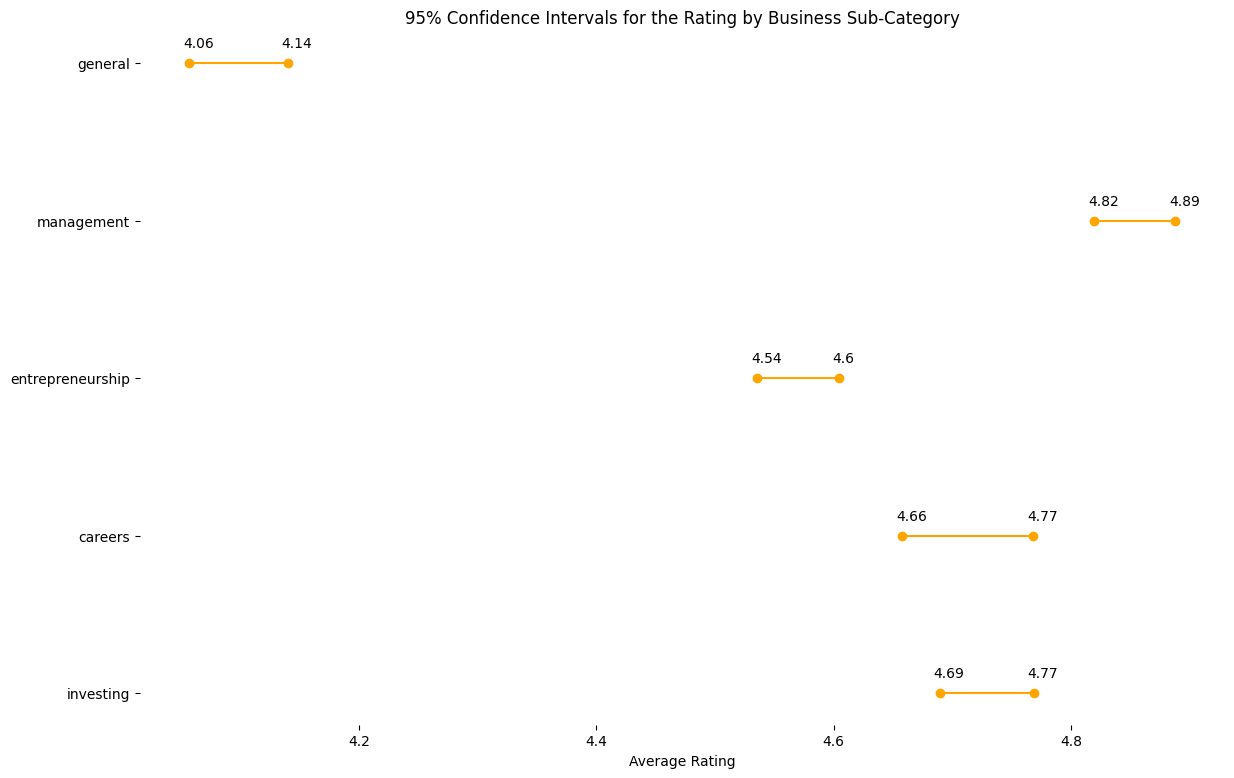

In [66]:
fig = plt.figure(figsize=(14, 9))
remove_borders()
y = -1
for key in business_confidence_intervals.keys():
    lower = business_confidence_intervals[key][0]
    upper = business_confidence_intervals[key][1]
    y += 1
    plt.plot((lower,upper),(y,y),'ro-',color='orange');
    plt.annotate(text = round(lower, 2), xy = (lower-0.005, y + 0.1))
    plt.annotate(text = round(upper, 2), xy = (upper-0.005, y + 0.1))


plt.yticks(range(len(business_confidence_intervals.keys())),list(business_confidence_intervals.keys()));
plt.xlabel('Average Rating')
plt.title("95% Confidence Intervals for the Rating by Business Sub-Category");

From both the Confidence intervals & the averages it is indicated that when a podcast is labeled to be only a `"general"` business podcast, it garners a worse rating compared to if the main genre was attached with another sub-category. Additionally, it seems as though the best performing sub-category for the business podcast genre is the `management` section - perhaps only individuals that have high expertise in management create podcasts and thus can provide a better product compared to the other counterparts. Let's discern whether this difference is actually statistically significant by comparing the general value with the smallest mean value out of the 4 sub-categories (`entrepreneurship`).

We assume that the rating for general business podcasts mean is higher or equal than the average rating for other sub-categorized business podcasts. And we look for the contrary alternative hypothesis.

H0 : `rating_general` >= `rating_entrepreneurship`

H1 : `rating_general` < `rating_entrepreneurship`

Significance Level: `5%`

In [67]:
results = ztest(general, entrepreneurship, value=0, alternative="smaller")
print(f"We reject the null hypothesis, because the {round(results[1], 3)} < 0.05.")
print("Which means that the true population rating for general business podcasts is LOWER than the true population average rating for other sub-categorized business podcasts.")

We reject the null hypothesis, because the 0.0 < 0.05.
Which means that the true population rating for general business podcasts is LOWER than the true population average rating for other sub-categorized business podcasts.


In [68]:
query_drop_table = """drop table master_table"""
execute_query(query_drop_table);

# Conclusions

* `Society-culture` Podcasts Analysis
    * With 95% confidence, we can specify that the true population of the mean sentiment compound score for `Society-culture` podcasts is between `0.5858843807976221` & `0.5946764504135423`. 
* `History` - `Science` Podcasts comparison
    * The difference between the mean `ratings` of podcasts specializing towards `history` and `science` is insignificant.
    * The true population mean `compound sentiment scores` between podcasts specializing towards `history` and `science` is different.
    * The true population proportions of positive reviews between podcasts specializing towards `history` and `science` is the same and falls on ~82-86%.
* `News` Podcast Negativity
    * `News` podcasts gather lower proportions of `positive` reviews than other podcast categories on average.
    * The true population mean `sentiment compound score` for `news` podcasts is `smaller` than the true population mean sentiment compound score for `other podcast categories`.
* `Comedy` Podcast Positivity
    * `Comedy` podcasts DO NOT gather the highest proportion of `positive` reviews compared to other categories on average.
    * The true population `sentiment compound score` for `comedy` podcasts is `lower` than the true population sentiment score for the `health podcast` category on average.
* `Adult-centric` vs `Child-centric` Education Podcasts
    * The true population mean `ratings` of `adult-centric` educational podcasts are `higher` than that of `children-centric` educational podcasts.
    * The true population mean `compound sensitivity scores` of `adult-centric` educational podcasts is `higher` than that of children-centric educational podcasts.
    * `Adult-centric` educational podcasts gather `higher` proportions of `positive` reviews than `children-centric` educational podcasts on average.
* `Business` Podcasts Subcategories
    * The true population `rating` for general `business` podcasts is `LOWER` than the true population average rating for other `sub-categorized business podcasts`.
    * With 95% confidence, the best performing `business` category podcasts are ones that have the sub-category `management`. 

# Potential Improvements

* Building a more specialized Sentiment Prediction model that would be more accurate for the specific use case via other `Classification` methods. This would potentially give us a more comprehensive spread of the actual positivity of each review.
* Incorporate other independent sample mean tests that check for the same result using the `median` as the test statistic instead of the `mean` to check for robusness of the results
* Introducing tests for checking the normality of a dataset (e.g. checking for `skewness`, `excess kurtosis` or any abnormalities in the dataset)
* Create a boolean variable of whether the review had emojis or not and whether the emoji-less reviews gave better `ratings` or `sentiment compound scores`
* Checking for whether there were malicious actors specifically trying to lower the rating of specific podcasts by specifically writing bad reviews and rating (e.g. whether some authorIDs had specifically written many reviews and all of them are very negative)